In [3]:
# !pip install upsetplot

# Misclassified Images

This notebook explores and displays misclassified images for each model trained as a part of our original experimentation. This includes all different RandAugment models.

For each model (resnet, densenet, etc) there is a general pattern:
* Model trained on original data
    * Display images incorrectly classified with highest confidence on CIFAR-10 test set
    * Display images incorrectly classified with highest confidence on CIFAR-10.1 test set
* Model trained on RandAugment data, RA(1,20)
    * Display images incorrectly classified with highest confidence on CIFAR-10 test set
    * Display images incorrectly classified with highest confidence on CIFAR-10.1 test set
* Model trained on RandAugment data, RA(2,5)
    * Display images incorrectly classified with highest confidence on CIFAR-10 test set
    * Display images incorrectly classified with highest confidence on CIFAR-10.1 test set
* Model trained on RandAugment data, RA(2,20)
    * Display images incorrectly classified with highest confidence on CIFAR-10 test set
    * Display images incorrectly classified with highest confidence on CIFAR-10.1 test set
* Model trained on RandAugment data, RA(3,20)
    * Display images incorrectly classified with highest confidence on CIFAR-10 test set
    * Display images incorrectly classified with highest confidence on CIFAR-10.1 test set
* Create overlap plot to compare images misclassified by multiple models for CIFAR-10 test set
* Create overlap plot to compare images misclassified by multiple models for CIFAR-10.1 test set

In [48]:
from ast import literal_eval
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import plot 
from matplotlib import pyplot
%matplotlib inline

In [49]:
search_path = "../model_results/"
file_extension = "*.csv"

dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]


df_orig = pd.concat(dfs, ignore_index=True)
df_orig.drop(['Original_Accuracy_300epochs', 'Original_CI_300epochs'], axis = 1, inplace = True)

# df_orig['Accuracy'] = df_orig['Accuracy'].apply(lambda x: x*100)
# df_orig['Original_CI'] = df_orig.Original_CI.apply(lambda x: literal_eval(x))
# df_orig['Orig_CI_Low'], df_orig['Orig_CI_Hi'] = zip(*df_orig.Original_CI)

# Filter data into subsets based on test dataset used
df_orig_cifar10 = df_orig[df_orig['Testset'] == 'cifar10']
df_orig_cifar101 = df_orig[df_orig['Testset'] == 'cifar10.1']

In [50]:
df_orig_cifar10

Model  Epoch  Testset    Loss  \
0               resnet_basic_32_ra_2_20_c10val    400  cifar10  1.8833   
3    resnet_basic_32_ra_2_20_c10val_refined400     50  cifar10  0.4247   
4                     resnext_29_4x64d_ra_2_20    400  cifar10  0.7273   
6          resnext_29_4x64d_ra_2_20_refined400     50  cifar10  0.2439   
8                     wrn_28_10_ra_2_20_c10val    400  cifar10  0.6113   
..                                         ...    ...      ...     ...   
199                 densenet_BC_100_12_ra_3_20    400  cifar10  1.6702   
200                 densenet_BC_100_12_ra_3_20    300  cifar10  1.5314   
204      densenet_BC_100_12_ra_3_20_refined400     50  cifar10  0.3489   
205                    resnet_basic_32_cm_1_.5    400  cifar10  2.2737   
208         resnet_basic_32_cm_1_.5_refined400     50  cifar10  0.4136   

     Accuracy  Original_Accuracy   Original_CI  
0      0.7127               92.5  (92.0, 93.0)  
3      0.8693               92.5  (92.0, 93.0)  
4      0.7895                NaN           NaN  
6      0.9260                NaN           NaN  
8      0.8456               92.5  (92.0, 93.0)  
..        ...                ...           ...  
199    0.7115               95.5  (95.1, 95.9)  
200    0.7140               95.5  (95.1, 95.9)  
204    0.9076               95.5  (95.1, 95.9)  
205    0.4043               92.5  (92.0, 93.0)  
208    0.9054               92.5  (92.0, 93.0)  

[110 rows x 7 columns]

### now look into difference in images misclassified

In [51]:
# Retrieve the official labels of the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
                                       download=True)
test_labels_CIFAR10 = testset.targets
test_data_CIFAR10 = testset.data

# Retrieve the official labels of the CIFAR10.1 test dataset
test_labels_CIFAR101 =np.load('../data/cifar101/cifar10.1_v6_labels.npy')  
test_data_CIFAR101 = np.load('../data/cifar101/cifar10.1_v6_data.npy')

# Create a dictionary that maps numeric class number to class name|
class_dict = {0: "airplane",
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"
}

classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile, test_labels):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels_CIFAR10 == zfile['labels']), "of", 
          len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, zfile['labels'], target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())


Files already downloaded and verified


In [52]:
number_to_analyze = 20

def error_by_r_score(zfile, test_labels, testset):
    images_to_print = []
    
    # Determine the probability we associatd with our predicted label
    pp_max = np.max(zfile['probs'], axis=1)

    # Retrieve the model's predicted probability of the correct label
    pp_correct = zfile['probs'][range(zfile['probs'].shape[0]), test_labels]

    # Calculate the R ratio for each document
    r = pp_max/pp_correct

    # Retrieve the row numbers where the R score is the highest
    max_r_value_indexes = r.argsort()[-1 * number_to_analyze:]

    # Create list to hold stats on highest R Score images
    stats = []
    
    for mi in max_r_value_indexes:
        #print("-- R Ratio:", r[mi], " ( index", mi, 
        #      ")\n   Guessed Label:", zfile['labels'][mi], class_dict[zfile['labels'][mi]], 
        #      "\n   Correct Label:", test_labels[mi], class_dict[test_labels[mi]],
        #      "\n   Class Probs:", zfile['probs'][mi], "\n")
        
        img_dict = {'prob_predicted': pp_max[mi],
                    'prob_correct': pp_correct[mi],
                    'r_value': r[mi],
                    'label_predicted_id': zfile['labels'][mi],
                    'label_predicted': class_dict[zfile['labels'][mi]],
                    'correct_label': test_labels[mi],
                    'correct_label_id': class_dict[test_labels[mi]],
                    'img_index': mi
                   }

        img=Image.fromarray(testset[mi])
        images_to_print.append(img)
        stats.append(img_dict)
        


    # Print the misclassified images
    fig = plt.figure(figsize=(16, 4))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(2, 10),  
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, images_to_print):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        
    return pd.DataFrame(stats)

### resnet 32, no ra

In [53]:

output = search_path + 'resnet_basic_32/predictions_160.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9232
 -> Sanity Check: 9232 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.918208  0.9430  0.930439   1000.0000
1 automobile   0.965966  0.9650  0.965483   1000.0000
2 bird         0.898899  0.8980  0.898449   1000.0000
3 cat          0.848423  0.8340  0.841150   1000.0000
4  deer        0.916091  0.9280  0.922007   1000.0000
5 dog          0.883249  0.8700  0.876574   1000.0000
6 frog         0.951613  0.9440  0.947791   1000.0000
7 horse        0.948847  0.9460  0.947421   1000.0000
8 ship         0.953047  0.9540  0.953523   1000.0000
9 truck        0.946215  0.9500  0.948104   1000.0000
accuracy       0.923200  0.9232  0.923200      0.9232
macro avg      0.923056  0.9232  0.923094  10000.0000
weighted avg   0.923056  0.9232  0.923094  10000.0000


In [54]:
output = search_path + 'resnet_basic_32/predictions_160_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.832
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.808743   0.740  0.772846   200.000
1 automobile   0.932515   0.760  0.837466   200.000
2 bird         0.795349   0.855  0.824096   200.000
3 cat          0.711340   0.690  0.700508   200.000
4  deer        0.866995   0.880  0.873449   200.000
5 dog          0.814070   0.810  0.812030   200.000
6 frog         0.880597   0.885  0.882793   200.000
7 horse        0.895000   0.895  0.895000   200.000
8 ship         0.831776   0.890  0.859903   200.000
9 truck        0.802632   0.915  0.855140   200.000
accuracy       0.832000   0.832  0.832000     0.832
macro avg      0.833902   0.832  0.831323  2000.000
weighted avg   0.833902   0.832  0.831323  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


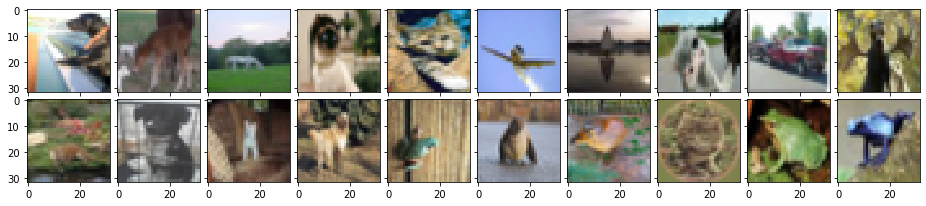

In [55]:
df_resnet32_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [56]:
df_resnet32_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.769989  6.086133e-07  1.265154e+06                   0   
1         0.999595  7.834623e-07  1.275869e+06                   4   
2         0.976585  7.560041e-07  1.291772e+06                   0   
3         0.999999  6.714246e-07  1.489369e+06                   5   
4         1.000000  4.381533e-07  2.282305e+06                   2   
5         1.000000  2.810098e-07  3.558594e+06                   2   
6         0.999998  2.286959e-07  4.372610e+06                   0   
7         0.908763  1.495513e-07  6.076595e+06                   5   
8         1.000000  9.241577e-08  1.082066e+07                   9   
9         0.999861  5.133766e-08  1.947617e+07                   2   
10        0.999999  3.688057e-08  2.711451e+07                   4   
11        0.994623  3.585000e-08  2.774402e+07                   3   
12        0.999566  3.225384e-08  3.099062e+07                   3   
13        0.999998  1.806433e-08  5.535761e+07                   4   
14        0.999899  1.671739e-08  5.981191e+07                   2   
15        0.999990  1.473961e-08  6.784368e+07                   3   
16        1.000000  6.862647e-09  1.457164e+08                   2   
17        1.000000  1.167653e-09  8.564185e+08                   6   
18        1.000000  7.037927e-10  1.420873e+09                   6   
19        0.999938  4.876184e-10  2.050656e+09                   2   

   label_predicted  correct_label correct_label_id  img_index  
0         airplane              5              dog       2525  
1             deer              7            horse       8943  
2         airplane              7            horse       4036  
3              dog              3              cat       1779  
4             bird              3              cat       1905  
5             bird              0         airplane       5454  
6         airplane              8             ship       5548  
7              dog              2             bird       7657  
8            truck              1       automobile       9227  
9             bird              4             deer       2785  
10            deer              3              cat       4965  
11             cat              5              dog       2590  
12             cat              5              dog       4740  
13            deer              5              dog       4528  
14            bird              6             frog       1935  
15             cat              2             bird       9704  
16            bird              4             deer       1765  
17            frog              3              cat       5511  
18            frog              3              cat       2405  
19            bird              6             frog       3615

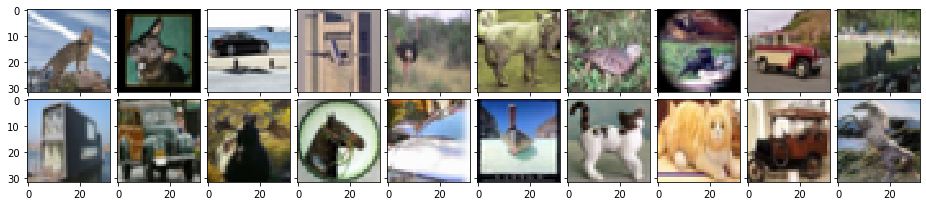

In [57]:
df_resnet32_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [58]:
df_resnet32_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999958  2.097298e-05  4.767841e+04                   2   
1         0.999980  1.765366e-05  5.664436e+04                   3   
2         0.999982  1.750031e-05  5.714080e+04                   0   
3         0.531151  9.019657e-06  5.888811e+04                   3   
4         0.995534  1.316287e-05  7.563194e+04                   3   
5         0.992970  7.657860e-06  1.296668e+05                   7   
6         0.999989  5.556863e-06  1.799557e+05                   6   
7         0.564810  3.126767e-06  1.806371e+05                   8   
8         0.999996  3.651222e-06  2.738799e+05                   9   
9         0.984561  3.139550e-06  3.135993e+05                   0   
10        0.999980  2.688646e-06  3.719268e+05                   9   
11        0.999995  1.449664e-06  6.898116e+05                   9   
12        0.978567  1.180461e-06  8.289700e+05                   2   
13        0.999866  1.098775e-06  9.099828e+05                   6   
14        0.996723  8.209000e-07  1.214184e+06                   0   
15        0.998175  6.976672e-07  1.430732e+06                   0   
16        1.000000  4.174091e-07  2.395730e+06                   5   
17        0.999995  4.079478e-07  2.451283e+06                   5   
18        0.999998  3.892159e-07  2.569263e+06                   9   
19        0.992908  2.610551e-08  3.803443e+07                   3   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              3              cat        686  
1              cat              5              dog       1126  
2         airplane              1       automobile        221  
3              cat              0         airplane         98  
4              cat              2             bird        482  
5            horse              3              cat        641  
6             frog              2             bird        513  
7             ship              5              dog       1060  
8            truck              1       automobile        254  
9         airplane              7            horse       1426  
10           truck              8             ship       1761  
11           truck              1       automobile        392  
12            bird              4             deer        936  
13            frog              7            horse       1412  
14        airplane              1       automobile        304  
15        airplane              8             ship       1621  
16             dog              3              cat        600  
17             dog              3              cat        602  
18           truck              1       automobile        391  
19             cat              7            horse       1528

### resnet with RA(1,20)

In [59]:
output = search_path + 'resnet_basic_32_ra_1_20/predictions_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.8897
 -> Sanity Check: 8897 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.874881  0.9160  0.894968   1000.0000
1 automobile   0.959555  0.9490  0.954248   1000.0000
2 bird         0.861680  0.8410  0.851215   1000.0000
3 cat          0.770243  0.7610  0.765594   1000.0000
4  deer        0.874757  0.9010  0.887685   1000.0000
5 dog          0.839671  0.8170  0.828180   1000.0000
6 frog         0.908640  0.9150  0.911809   1000.0000
7 horse        0.941718  0.9210  0.931244   1000.0000
8 ship         0.940464  0.9320  0.936213   1000.0000
9 truck        0.924584  0.9440  0.934191   1000.0000
accuracy       0.889700  0.8897  0.889700      0.8897
macro avg      0.889619  0.8897  0.889535  10000.0000
weighted avg   0.889619  0.8897  0.889535  10000.0000


In [60]:
output = search_path + 'resnet_basic_32_ra_1_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8005
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.770732  0.7900  0.780247   200.0000
1 automobile   0.960784  0.7350  0.832861   200.0000
2 bird         0.735294  0.7500  0.742574   200.0000
3 cat          0.646789  0.7050  0.674641   200.0000
4  deer        0.774648  0.8250  0.799031   200.0000
5 dog          0.787129  0.7950  0.791045   200.0000
6 frog         0.851282  0.8300  0.840506   200.0000
7 horse        0.907609  0.8350  0.869792   200.0000
8 ship         0.860000  0.8600  0.860000   200.0000
9 truck        0.778761  0.8800  0.826291   200.0000
accuracy       0.800500  0.8005  0.800500     0.8005
macro avg      0.807303  0.8005  0.801699  2000.0000
weighted avg   0.807303  0.8005  0.801699  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


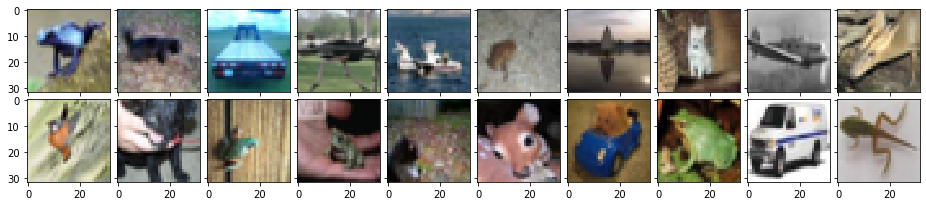

In [61]:
df_resnet32_errors_ra_1_20 = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [62]:
df_resnet32_errors_ra_1_20

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.997945  2.346823e-05  4.252326e+04                   2   
1         0.999972  1.816082e-05  5.506205e+04                   4   
2         0.951111  1.541772e-05  6.168950e+04                   8   
3         0.999976  1.426829e-05  7.008380e+04                   0   
4         0.999969  1.399443e-05  7.145484e+04                   8   
5         0.776890  9.687787e-06  8.019270e+04                   4   
6         0.998701  9.941819e-06  1.004546e+05                   0   
7         0.993327  7.623324e-06  1.303011e+05                   8   
8         0.999994  6.465965e-06  1.546550e+05                   8   
9         0.747030  4.272170e-06  1.748597e+05                   0   
10        0.918633  4.728117e-06  1.942914e+05                   6   
11        0.999443  5.114603e-06  1.954097e+05                   4   
12        0.992096  4.239384e-06  2.340189e+05                   2   
13        0.998192  2.424440e-06  4.117204e+05                   3   
14        0.999982  1.593188e-06  6.276609e+05                   6   
15        0.999947  1.260356e-06  7.933847e+05                   5   
16        0.998399  7.175223e-07  1.391454e+06                   1   
17        0.999997  5.991773e-07  1.668950e+06                   6   
18        1.000000  9.103507e-08  1.098478e+07                   1   
19        0.999999  6.977534e-10  1.433170e+09                   0   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              6             frog       3615  
1             deer              3              cat       7496  
2             ship              9            truck       4931  
3         airplane              2             bird       7068  
4             ship              0         airplane       4784  
5             deer              6             frog       6063  
6         airplane              8             ship       5548  
7             ship              5              dog       4906  
8             ship              0         airplane        422  
9         airplane              4             deer       6753  
10            frog              2             bird       2675  
11            deer              5              dog       4139  
12            bird              6             frog       1935  
13             cat              6             frog       3075  
14            frog              3              cat       7797  
15             dog              4             deer       4112  
16      automobile              3              cat       6859  
17            frog              3              cat       2405  
18      automobile              9            truck       5416  
19        airplane              6             frog       8573

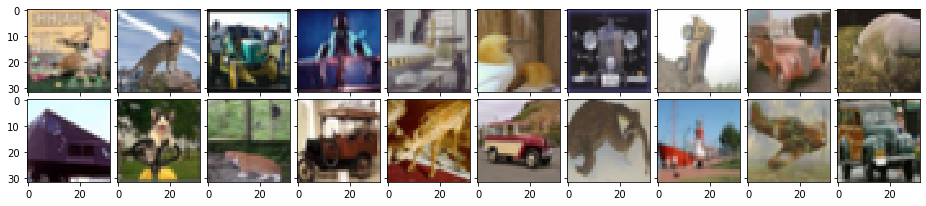

In [63]:
df_resnet32_errors_101_ra_1_20  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [64]:
df_resnet32_errors_101_ra_1_20

prob_predicted  prob_correct        r_value  label_predicted_id  \
0         0.993963      0.000177    5627.195801                   4   
1         0.820755      0.000144    5702.770996                   4   
2         0.999394      0.000168    5935.674805                   9   
3         0.991695      0.000161    6165.648438                   7   
4         0.541568      0.000078    6920.393555                   3   
5         0.988679      0.000132    7461.914551                   3   
6         0.831688      0.000109    7641.250977                   9   
7         0.494574      0.000061    8084.728027                   5   
8         0.974470      0.000066   14702.484375                   9   
9         0.904562      0.000056   16015.457031                   2   
10        0.999940      0.000057   17564.363281                   9   
11        0.999563      0.000051   19761.595703                   7   
12        0.978924      0.000044   22448.521484                   4   
13        0.998331      0.000031   31698.150391                   9   
14        0.998934      0.000028   35935.402344                   6   
15        0.999993      0.000007  137463.515625                   9   
16        0.998341      0.000005  201671.546875                   3   
17        0.999982      0.000002  431664.843750                   0   
18        0.998965      0.000002  441568.687500                   6   
19        0.999996      0.000002  460554.718750                   9   

   label_predicted  correct_label correct_label_id  img_index  
0             deer              5              dog       1072  
1             deer              3              cat        686  
2            truck              1       automobile        379  
3            horse              0         airplane         47  
4              cat              0         airplane        108  
5              cat              2             bird        420  
6            truck              1       automobile        382  
7              dog              9            truck       1811  
8            truck              1       automobile        341  
9             bird              7            horse       1511  
10           truck              0         airplane         12  
11           horse              3              cat        706  
12            deer              3              cat        699  
13           truck              1       automobile        391  
14            frog              4             deer        910  
15           truck              1       automobile        254  
16             cat              6             frog       1219  
17        airplane              8             ship       1718  
18            frog              0         airplane        199  
19           truck              1       automobile        392

### resnet 32 w/ ra 25

In [65]:

output = search_path + 'resnet_basic_32_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.8766
 -> Sanity Check: 8766 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.877395  0.9160  0.896282   1000.0000
1 automobile   0.958502  0.9470  0.952716   1000.0000
2 bird         0.838906  0.8280  0.833417   1000.0000
3 cat          0.744681  0.7350  0.739809   1000.0000
4  deer        0.843396  0.8940  0.867961   1000.0000
5 dog          0.791709  0.7830  0.787330   1000.0000
6 frog         0.915907  0.9040  0.909914   1000.0000
7 horse        0.935349  0.8970  0.915773   1000.0000
8 ship         0.935157  0.9230  0.929039   1000.0000
9 truck        0.927866  0.9390  0.933400   1000.0000
accuracy       0.876600  0.8766  0.876600      0.8766
macro avg      0.876887  0.8766  0.876564  10000.0000
weighted avg   0.876887  0.8766  0.876564  10000.0000


In [66]:
output = search_path + 'resnet_basic_32_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.779
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.721649   0.700  0.710660   200.000
1 automobile   0.931250   0.745  0.827778   200.000
2 bird         0.773684   0.735  0.753846   200.000
3 cat          0.633028   0.690  0.660287   200.000
4  deer        0.771028   0.825  0.797101   200.000
5 dog          0.734375   0.705  0.719388   200.000
6 frog         0.836634   0.845  0.840796   200.000
7 horse        0.846154   0.825  0.835443   200.000
8 ship         0.811594   0.840  0.825553   200.000
9 truck        0.771930   0.880  0.822430   200.000
accuracy       0.779000   0.779  0.779000     0.779
macro avg      0.783133   0.779  0.779328  2000.000
weighted avg   0.783133   0.779  0.779328  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


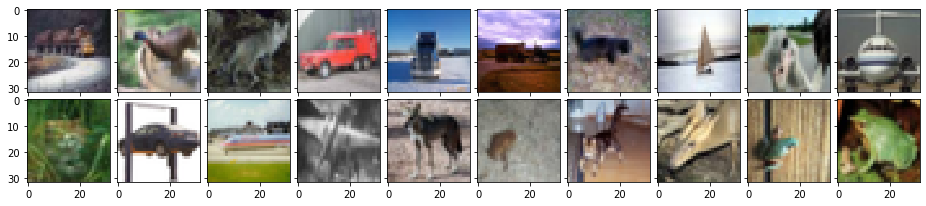

In [67]:
df_resnet32_errors_ra_2_5 = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [68]:
df_resnet32_errors_ra_2_5

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999080  2.654312e-05  3.763990e+04                   8   
1         0.999782  1.644868e-05  6.078189e+04                   7   
2         0.999593  1.588650e-05  6.292093e+04                   6   
3         0.999985  1.550530e-05  6.449307e+04                   1   
4         0.999952  1.230098e-05  8.129048e+04                   0   
5         0.999986  1.080741e-05  9.252783e+04                   0   
6         0.998719  6.897345e-06  1.447976e+05                   4   
7         0.999995  5.108746e-06  1.957417e+05                   0   
8         0.964780  3.630401e-06  2.657503e+05                   5   
9         0.999994  3.493923e-06  2.862097e+05                   8   
10        0.997877  3.458779e-06  2.885056e+05                   6   
11        0.845098  1.954187e-06  4.324548e+05                   0   
12        0.999996  1.726287e-06  5.792759e+05                   8   
13        0.988745  1.664335e-06  5.940783e+05                   4   
14        0.999935  1.159235e-06  8.625812e+05                   4   
15        0.999614  7.768206e-07  1.286801e+06                   4   
16        0.999901  7.248466e-07  1.379466e+06                   7   
17        0.999272  7.074605e-07  1.412477e+06                   2   
18        0.950691  9.435750e-08  1.007541e+07                   2   
19        1.000000  3.085928e-10  3.240516e+09                   6   

   label_predicted  correct_label correct_label_id  img_index  
0             ship              9            truck       2495  
1            horse              2             bird       4244  
2             frog              3              cat        862  
3       automobile              9            truck       6522  
4         airplane              9            truck       6545  
5         airplane              9            truck       3957  
6             deer              3              cat       7496  
7         airplane              8             ship       2705  
8              dog              2             bird       7657  
9             ship              0         airplane       1072  
10            frog              3              cat       3977  
11        airplane              1       automobile       3828  
12            ship              0         airplane       2473  
13            deer              0         airplane       7816  
14            deer              7            horse       5690  
15            deer              6             frog       6063  
16           horse              3              cat       4485  
17            bird              4             deer       6753  
18            bird              6             frog       1935  
19            frog              3              cat       2405

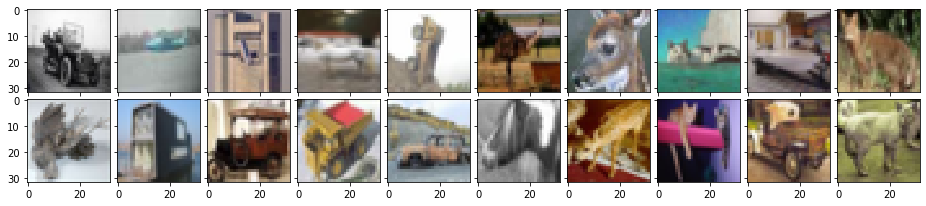

In [69]:
df_resnet32_errors_101_ra_2_5  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [70]:
df_resnet32_errors_101_ra_2_5

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999651  2.765867e-04  3.614242e+03                   9   
1         0.999720  2.511136e-04  3.981149e+03                   8   
2         0.607016  1.274724e-04  4.761940e+03                   3   
3         0.999368  1.746133e-04  5.723322e+03                   0   
4         0.664067  9.640786e-05  6.888103e+03                   5   
5         0.988985  1.245702e-04  7.939182e+03                   7   
6         0.999545  1.009981e-04  9.896674e+03                   5   
7         0.974293  7.940245e-05  1.227031e+04                   0   
8         0.997369  7.881265e-05  1.265494e+04                   9   
9         0.998231  7.521459e-05  1.327178e+04                   4   
10        0.701462  5.239005e-05  1.338922e+04                   6   
11        0.999826  6.844223e-05  1.460831e+04                   9   
12        0.999145  4.073908e-05  2.452547e+04                   9   
13        0.755374  2.932136e-05  2.576192e+04                   6   
14        0.999656  2.998520e-05  3.333833e+04                   9   
15        0.852026  2.513239e-05  3.390152e+04                   5   
16        0.998022  2.191398e-05  4.554272e+04                   6   
17        0.997109  7.451331e-06  1.338162e+05                   1   
18        0.999993  7.042334e-06  1.419973e+05                   9   
19        0.998127  8.990767e-07  1.110169e+06                   7   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        283  
1             ship              0         airplane        177  
2              cat              0         airplane         98  
3         airplane              7            horse       1435  
4              dog              9            truck       1811  
5            horse              2             bird        571  
6              dog              4             deer        901  
7         airplane              3              cat        702  
8            truck              8             ship       1727  
9             deer              3              cat        668  
10            frog              2             bird        433  
11           truck              8             ship       1761  
12           truck              1       automobile        391  
13            frog              9            truck       1824  
14           truck              1       automobile        265  
15             dog              7            horse       1585  
16            frog              4             deer        910  
17      automobile              3              cat        732  
18           truck              1       automobile        336  
19           horse              3              cat        641

# resnet 32, ra 2 20

In [71]:

output = search_path + 'resnet_basic_32_ra_2_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.867
 -> Sanity Check: 8670 of 10000 correct

              precision  recall  f1-score    support
0 airplane     0.878122   0.879  0.878561   1000.000
1 automobile   0.944106   0.929  0.936492   1000.000
2 bird         0.810078   0.836  0.822835   1000.000
3 cat          0.738269   0.708  0.722818   1000.000
4  deer        0.839471   0.889  0.863526   1000.000
5 dog          0.801026   0.781  0.790886   1000.000
6 frog         0.901478   0.915  0.908189   1000.000
7 horse        0.924290   0.879  0.901076   1000.000
8 ship         0.908649   0.935  0.921636   1000.000
9 truck        0.923618   0.919  0.921303   1000.000
accuracy       0.867000   0.867  0.867000      0.867
macro avg      0.866911   0.867  0.866732  10000.000
weighted avg   0.866911   0.867  0.866732  10000.000


In [72]:
output = search_path + 'resnet_basic_32_ra_2_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.7685
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.755319  0.7100  0.731959   200.0000
1 automobile   0.941558  0.7250  0.819209   200.0000
2 bird         0.733333  0.7150  0.724051   200.0000
3 cat          0.619718  0.6600  0.639225   200.0000
4  deer        0.760369  0.8250  0.791367   200.0000
5 dog          0.751323  0.7100  0.730077   200.0000
6 frog         0.812808  0.8250  0.818859   200.0000
7 horse        0.826531  0.8100  0.818182   200.0000
8 ship         0.767442  0.8250  0.795181   200.0000
9 truck        0.765217  0.8800  0.818605   200.0000
accuracy       0.768500  0.7685  0.768500     0.7685
macro avg      0.773362  0.7685  0.768671  2000.0000
weighted avg   0.773362  0.7685  0.768671  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


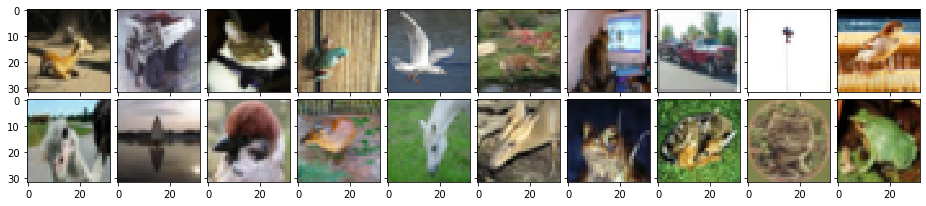

In [73]:
df_resnet32_errors_ra_2_20 = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [74]:
df_resnet32_errors_ra_2_20

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.996151  9.132718e-05  1.090750e+04                   0   
1         0.960837  8.589136e-05  1.118666e+04                   3   
2         0.990263  8.374614e-05  1.182458e+04                   6   
3         0.990738  7.545416e-05  1.313033e+04                   2   
4         0.996973  7.377886e-05  1.351299e+04                   0   
5         0.976763  6.212041e-05  1.572370e+04                   4   
6         0.999825  5.857813e-05  1.706823e+04                   9   
7         0.999938  5.747140e-05  1.739888e+04                   9   
8         0.999885  5.677293e-05  1.761200e+04                   2   
9         0.961098  5.363944e-05  1.791774e+04                   7   
10        0.926417  4.734848e-05  1.956593e+04                   5   
11        0.999420  4.936789e-05  2.024434e+04                   0   
12        0.998986  4.806948e-05  2.078213e+04                   5   
13        0.999339  4.110275e-05  2.431318e+04                   2   
14        0.855811  2.987663e-05  2.864481e+04                   4   
15        0.920609  2.404478e-05  3.828727e+04                   2   
16        0.997070  2.119545e-05  4.704167e+04                   3   
17        0.998925  1.248957e-05  7.998075e+04                   6   
18        0.999979  2.926937e-06  3.416470e+05                   6   
19        0.999997  1.413965e-08  7.072288e+07                   6   

   label_predicted  correct_label correct_label_id  img_index  
0         airplane              4             deer       2581  
1              cat              9            truck       5151  
2             frog              3              cat        245  
3             bird              6             frog       1935  
4         airplane              2             bird       2542  
5             deer              3              cat       4965  
6            truck              3              cat       5176  
7            truck              1       automobile       9227  
8             bird              0         airplane       3444  
9            horse              2             bird       1150  
10             dog              2             bird       7657  
11        airplane              8             ship       5548  
12             dog              2             bird       4302  
13            bird              4             deer       1765  
14            deer              7            horse       4309  
15            bird              4             deer       6753  
16             cat              6             frog       1034  
17            frog              4             deer       2128  
18            frog              3              cat       5511  
19            frog              3              cat       2405

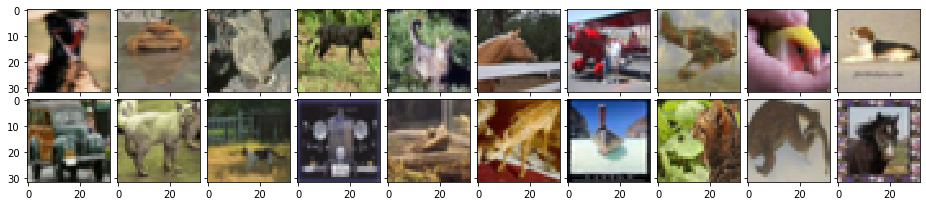

In [75]:
df_resnet32_errors_101_ra_2_20  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [76]:
df_resnet32_errors_101_ra_2_20

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.575018      0.000500   1150.375244                   5   
1         0.921814      0.000780   1181.826416                   8   
2         0.991139      0.000763   1298.990967                   6   
3         0.675944      0.000467   1447.747681                   7   
4         0.998460      0.000496   2012.540161                   2   
5         0.994558      0.000475   2092.943359                   8   
6         0.866659      0.000362   2391.539551                   9   
7         0.895449      0.000359   2491.023438                   6   
8         0.855882      0.000331   2581.872803                   3   
9         0.854890      0.000263   3249.347412                   2   
10        0.999697      0.000263   3796.014160                   9   
11        0.829241      0.000200   4153.164551                   7   
12        0.995193      0.000231   4309.413086                   4   
13        0.922898      0.000210   4386.277832                   9   
14        0.581512      0.000126   4625.733398                   4   
15        0.990730      0.000182   5429.429199                   6   
16        0.821864      0.000094   8721.108398                   2   
17        0.998859      0.000097  10268.492188                   6   
18        0.925291      0.000079  11688.810547                   3   
19        0.993387      0.000034  29045.974609                   3   

   label_predicted  correct_label correct_label_id  img_index  
0              dog              2             bird        492  
1             ship              6             frog       1265  
2             frog              2             bird        515  
3            horse              3              cat        743  
4             bird              3              cat        601  
5             ship              7            horse       1463  
6            truck              0         airplane         79  
7             frog              0         airplane        199  
8              cat              2             bird        428  
9             bird              5              dog       1161  
10           truck              1       automobile        392  
11           horse              3              cat        641  
12            deer              3              cat        772  
13           truck              1       automobile        382  
14            deer              6             frog       1216  
15            frog              4             deer        910  
16            bird              8             ship       1621  
17            frog              3              cat        605  
18             cat              6             frog       1219  
19             cat              7            horse       1536

### resnet 32, ra 3 20

In [77]:
output = search_path + 'resnet_basic_32_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.8546
 -> Sanity Check: 8546 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.867275  0.8560  0.861600   1000.0000
1 automobile   0.930514  0.9240  0.927245   1000.0000
2 bird         0.838745  0.7750  0.805613   1000.0000
3 cat          0.706781  0.7400  0.723009   1000.0000
4  deer        0.811853  0.8630  0.836646   1000.0000
5 dog          0.784334  0.7710  0.777610   1000.0000
6 frog         0.897281  0.8910  0.894129   1000.0000
7 horse        0.909744  0.8870  0.898228   1000.0000
8 ship         0.897585  0.9290  0.913022   1000.0000
9 truck        0.910000  0.9100  0.910000   1000.0000
accuracy       0.854600  0.8546  0.854600      0.8546
macro avg      0.855411  0.8546  0.854710  10000.0000
weighted avg   0.855411  0.8546  0.854710  10000.0000


In [78]:
output = search_path + 'resnet_basic_32_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.741
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.732620   0.685  0.708010   200.000
1 automobile   0.838150   0.725  0.777480   200.000
2 bird         0.726744   0.625  0.672043   200.000
3 cat          0.608511   0.715  0.657471   200.000
4  deer        0.724299   0.775  0.748792   200.000
5 dog          0.722513   0.690  0.705882   200.000
6 frog         0.809045   0.805  0.807018   200.000
7 horse        0.796954   0.785  0.790932   200.000
8 ship         0.750000   0.780  0.764706   200.000
9 truck        0.736607   0.825  0.778302   200.000
accuracy       0.741000   0.741  0.741000     0.741
macro avg      0.744544   0.741  0.741064  2000.000
weighted avg   0.744544   0.741  0.741064  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


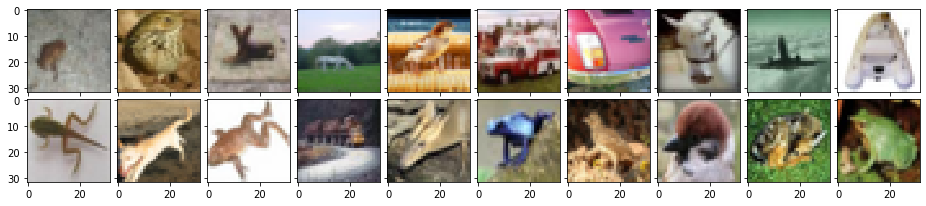

In [79]:
df_resnet32_errors_ra_3_20 = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [80]:
df_resnet32_errors_ra_3_20

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.998077  1.047517e-04  9.528028e+03                   4   
1         0.999870  9.255511e-05  1.080297e+04                   6   
2         0.998884  8.733530e-05  1.143734e+04                   4   
3         0.972891  8.496435e-05  1.145058e+04                   0   
4         0.948107  7.812346e-05  1.213601e+04                   4   
5         0.999925  7.064205e-05  1.415481e+04                   9   
6         0.942727  6.225733e-05  1.514242e+04                   8   
7         0.898497  4.411765e-05  2.036593e+04                   5   
8         0.999957  3.885743e-05  2.573399e+04                   8   
9         0.641516  2.287901e-05  2.803949e+04                   5   
10        0.983253  2.924764e-05  3.361820e+04                   0   
11        0.999571  2.716467e-05  3.679674e+04                   0   
12        0.603809  1.520098e-05  3.972174e+04                   3   
13        0.999080  2.348044e-05  4.254946e+04                   8   
14        0.754901  1.378477e-05  5.476344e+04                   2   
15        0.982366  1.070140e-05  9.179786e+04                   4   
16        0.999335  9.187313e-06  1.087734e+05                   6   
17        0.999761  3.478922e-06  2.873767e+05                   5   
18        0.999917  2.943978e-06  3.396484e+05                   6   
19        1.000000  6.097156e-09  1.640109e+08                   6   

   label_predicted  correct_label correct_label_id  img_index  
0             deer              6             frog       6063  
1             frog              2             bird       2226  
2             deer              5              dog       3192  
3         airplane              7            horse       4036  
4             deer              2             bird       1150  
5            truck              1       automobile       3560  
6             ship              1       automobile       2843  
7              dog              7            horse       2895  
8             ship              0         airplane        473  
9              dog              8             ship       2533  
10        airplane              6             frog       8573  
11        airplane              5              dog       4942  
12             cat              6             frog        893  
13            ship              9            truck       2495  
14            bird              4             deer       6753  
15            deer              6             frog       3615  
16            frog              2             bird       9982  
17             dog              2             bird       4302  
18            frog              4             deer       2128  
19            frog              3              cat       2405

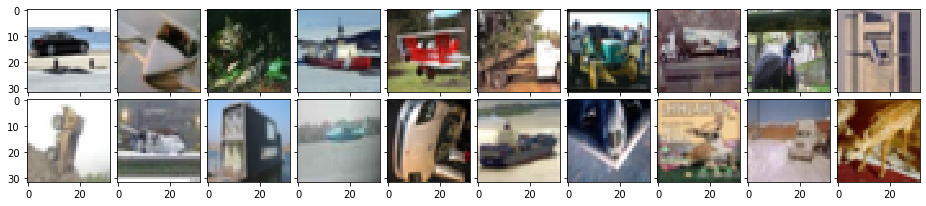

In [81]:
df_resnet32_errors_101_ra_3_20  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [82]:
df_resnet32_errors_101_ra_3_20

prob_predicted  prob_correct      r_value  label_predicted_id  \
0         0.992429      0.001965   505.066650                   0   
1         0.822935      0.001622   507.275543                   3   
2         0.987457      0.001837   537.616577                   6   
3         0.997632      0.001844   540.881165                   9   
4         0.992744      0.001819   545.654907                   9   
5         0.953991      0.001712   557.171814                   3   
6         0.997653      0.001725   578.205383                   9   
7         0.980648      0.001597   613.910095                   8   
8         0.853427      0.000770  1107.961182                   7   
9         0.968340      0.000850  1139.657104                   3   
10        0.509871      0.000347  1470.219727                   2   
11        0.999386      0.000538  1858.562012                   8   
12        0.995254      0.000464  2147.207031                   9   
13        0.999241      0.000411  2430.147705                   8   
14        0.991468      0.000392  2529.395996                   3   
15        0.942690      0.000340  2774.702637                   9   
16        0.999253      0.000358  2791.288086                   8   
17        0.985751      0.000176  5588.336914                   4   
18        0.498910      0.000062  7985.701172                   5   
19        0.986468      0.000119  8271.237305                   6   

   label_predicted  correct_label correct_label_id  img_index  
0         airplane              1       automobile        221  
1              cat              0         airplane        184  
2             frog              3              cat        739  
3            truck              8             ship       1770  
4            truck              0         airplane        171  
5              cat              9            truck       1814  
6            truck              1       automobile        379  
7             ship              9            truck       1835  
8            horse              2             bird        404  
9              cat              0         airplane         98  
10            bird              9            truck       1811  
11            ship              0         airplane        182  
12           truck              8             ship       1761  
13            ship              0         airplane        177  
14             cat              1       automobile        299  
15           truck              8             ship       1786  
16            ship              0         airplane         14  
17            deer              5              dog       1072  
18             dog              9            truck       1993  
19            frog              4             deer        910

### compare chart

The number of common misclassifications across all models: 1
{2405}


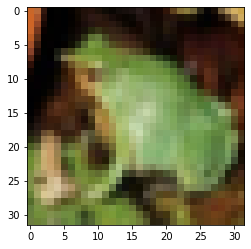

In [83]:
# View intersection of errors
#change the intersect
intersect = set(df_resnet32_errors.img_index) & \
            set(df_resnet32_errors_ra_1_20.img_index) & \
            set(df_resnet32_errors_ra_2_5.img_index) & \
            set(df_resnet32_errors_ra_2_20.img_index) & \
            set(df_resnet32_errors_ra_3_20.img_index)

print("The number of common misclassifications across all models:", len(intersect))
print(intersect)

# View errors 
# df_errors = pd.DataFrame({'resnext_29_4x64' : df_resnext4_errors.img_index,
#                           'resnext_29_8x64' : df_resnext8_errors.img_index,
#                           'resnet32' : df_resnet32_errors.img_index,
#                           'densenet' : df_densenet_errors.img_index,
#                           'wrn_28_10' : df_wrn_28_10_errors.img_index,
#                           'pyramidnet_basic_110_84' : df_pyramidnet_basic_110_84_errors.img_index,
#                           'resnet44' : df_resnet44_errors.img_index}
#                         )

images_to_print = []

for i in intersect:
    img=Image.fromarray(test_data_CIFAR10[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [84]:
df = pd.DataFrame()

# change these labels

# intersect = set(df_resnet32_errors.img_index) & \
#             set(df_resnet32_errors_ra_2_5.img_index) & \
#             set(df_resnet32_errors_ra_2_20.img_index) & \
#             set(df_resnet32_errors_ra_3_20.img_index)

for m, me in [('resnet32', df_resnet32_errors.img_index), 
              ('resnet32_ra_1_20', df_resnet32_errors_ra_1_20.img_index),
              ('resnet32_ra_2_5', df_resnet32_errors_ra_2_5.img_index), 
              ('resnet32_ra_2_20', df_resnet32_errors_ra_2_20.img_index), 
              ('resnet32_ra_3_20', df_resnet32_errors_ra_3_20.img_index)]:
    for e in me:
        df.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df.fillna(False, inplace=True)
cols = df.columns
df.reset_index(inplace=True)
df

index   2525   8943   4036   1779   1905   5454   5548   7657  \
0          resnet32   True   True   True   True   True   True   True   True   
1  resnet32_ra_1_20  False  False  False  False  False  False   True  False   
2   resnet32_ra_2_5  False  False  False  False  False  False  False   True   
3  resnet32_ra_2_20  False  False  False  False  False  False   True   True   
4  resnet32_ra_3_20  False  False   True  False  False  False  False  False   

    9227   2785   4965   2590   4740   4528   1935   9704   1765   5511  2405  \
0   True   True   True   True   True   True   True   True   True   True  True   
1  False  False  False  False  False  False   True  False  False  False  True   
2  False  False  False  False  False  False   True  False  False  False  True   
3   True  False   True  False  False  False   True  False   True   True  True   
4  False  False  False  False  False  False  False  False  False  False  True   

    3615   7496   4931   7068   4784   6063   4906    422   6753   2675  \
0   True  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True   True   True   True   True   
2  False   True  False  False  False   True  False  False   True  False   
3  False  False  False  False  False  False  False  False   True  False   
4   True  False  False  False  False   True  False  False   True  False   

    4139   3075   7797   4112   6859   5416   8573   2495   4244    862  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True   True  False  False  False   
2  False  False  False  False  False  False  False   True   True   True   
3  False  False  False  False  False  False  False  False  False  False   
4  False  False  False  False  False  False   True   True  False  False   

    6522   6545   3957   2705   1072   3977   3828   2473   7816   5690  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True   True   True   True   
3  False  False  False  False  False  False  False  False  False  False   
4  False  False  False  False  False  False  False  False  False  False   

    4485   2581   5151    245   2542   5176   3444   1150   4302   4309  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True  False  False  False  False  False  False  False  False  False   
3  False   True   True   True   True   True   True   True   True   True   
4  False  False  False  False  False  False  False   True   True  False   

    1034   2128   2226   3192   3560   2843   2895    473   2533   4942  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True  False  False  False  False  False  False  False  False   
4  False   True   True   True   True   True   True   True   True   True   

     893   9982  
0  False  False  
1  False  False  
2  False  False  
3  False  False  
4   True   True

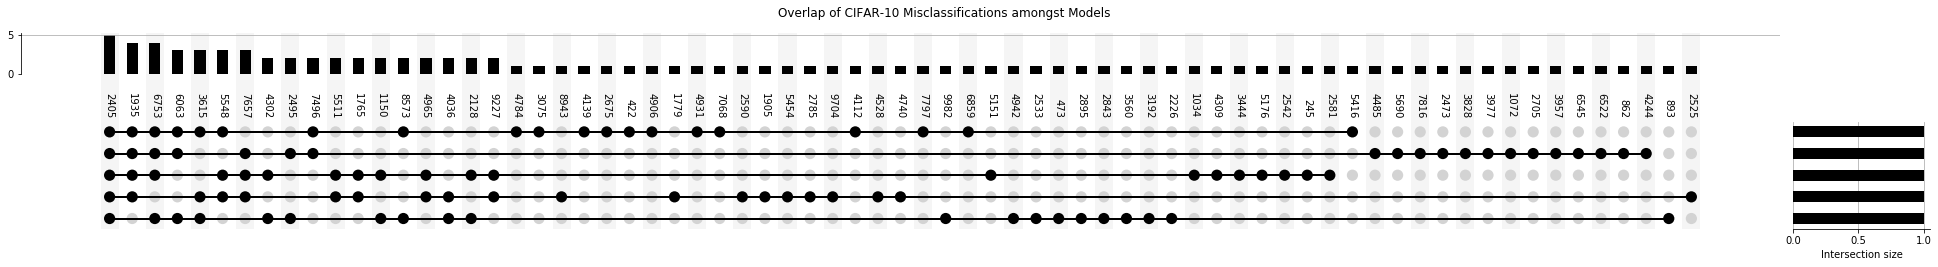

In [85]:
overlap = df.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show()  

In [86]:
# View intersection of errors
intersect101 = set(df_resnet32_errors_101.img_index) & \
            set(df_resnet32_errors_101_ra_1_20.img_index) & \
            set(df_resnet32_errors_101_ra_2_5.img_index) & \
            set(df_resnet32_errors_101_ra_2_20.img_index) & \
            set(df_resnet32_errors_101_ra_3_20.img_index)

            
print("The number of common misclassifications across all models:", len(intersect101))
print(intersect101)

# View errors 
# df_errors_101 = pd.DataFrame({'resnext_29_4x64' : df_resnext4_errors_101.img_index,
#                              'resnext_29_8x64' : df_resnext8_errors_101.img_index,
#                              'resnet32' : df_resnet32_errors_101.img_index,
#                              'densenet' : df_densenet_errors_101.img_index,
#                              'wrn_28_10' : df_wrn_28_10_errors_101.img_index,
#                              'pyramidnet_basic_110_84' : df_pyramidnet_basic_110_84_errors_101.img_index,
#                              'resnet44' : df_resnet44_errors.img_index})

images_to_print = []

for i in intersect101:
    img=Image.fromarray(test_data_CIFAR101[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect101)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

The number of common misclassifications across all models: 0
set()


IndexError: list index out of range

<Figure size 1152x288 with 0 Axes>

In [89]:
df101 = pd.DataFrame()

for m, me in [('resnet32', df_resnet32_errors_101.img_index), 
              ('resnet32_ra_1_20', df_resnet32_errors_101_ra_2_5.img_index), 
              ('resnet32_ra_2_5', df_resnet32_errors_101_ra_2_5.img_index), 
              ('resnet32_ra_2_20', df_resnet32_errors_101_ra_2_20.img_index), 
              ('resnet32_ra_3_20', df_resnet32_errors_101_ra_3_20.img_index)]:
    for e in me:
        df101.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df101.fillna(False, inplace=True)
cols = df101.columns
df101.reset_index(inplace=True)
df101

index    686   1126    221     98    482    641    513   1060  \
0          resnet32   True   True   True   True   True   True   True   True   
1  resnet32_ra_1_20  False  False  False   True  False   True  False  False   
2   resnet32_ra_2_5  False  False  False   True  False   True  False  False   
3  resnet32_ra_2_20  False  False  False  False  False   True  False  False   
4  resnet32_ra_3_20  False  False   True   True  False  False  False  False   

     254   1426   1761    392    936   1412    304   1621    600    602  \
0   True   True   True   True   True   True   True   True   True   True   
1  False  False   True  False  False  False  False  False  False  False   
2  False  False   True  False  False  False  False  False  False  False   
3  False  False  False   True  False  False  False   True  False  False   
4  False  False   True  False  False  False  False  False  False  False   

     391   1528    283    177   1435   1811    571    901    702   1727  \
0   True   True  False  False  False  False  False  False  False  False   
1   True  False   True   True   True   True   True   True   True   True   
2   True  False   True   True   True   True   True   True   True   True   
3  False  False  False  False  False  False  False  False  False  False   
4  False  False  False   True  False   True  False  False  False  False   

     668    433   1824    265   1585    910    732    336    492   1265  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True   True   True  False  False   
2   True   True   True   True   True   True   True   True  False  False   
3  False  False  False  False  False   True  False  False   True   True   
4  False  False  False  False  False   True  False  False  False  False   

     515    743    601   1463     79    199    428   1161    772    382  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True   True   True   True   True   True   True   True   
4  False  False  False  False  False  False  False  False  False  False   

    1216    605   1219   1536    184    739   1770    171   1814    379  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True   True  False  False  False  False  False  False   
4  False  False  False  False   True   True   True   True   True   True   

    1835    404    182    299   1786     14   1072   1993  
0  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  
4   True   True   True   True   True   True   True   True

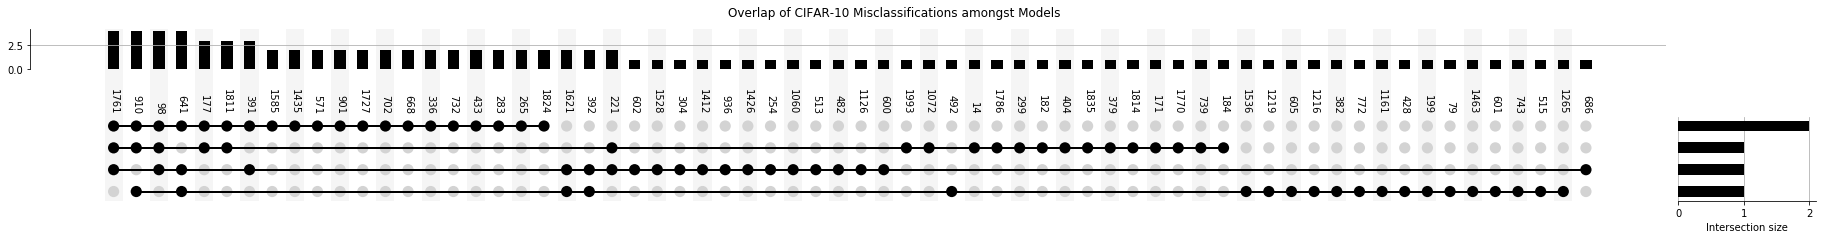

In [90]:
overlap = df101.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show() 

### now redo for wrn

### wrn_28_10, no RA

In [91]:
output = search_path + 'wrn_28_10/predictions_200.npz'
npzfile = np.load(output)

confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9578
 -> Sanity Check: 9578 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.953876  0.9720  0.962853   1000.0000
1 automobile   0.972305  0.9830  0.977623   1000.0000
2 bird         0.963115  0.9400  0.951417   1000.0000
3 cat          0.905584  0.8920  0.898741   1000.0000
4  deer        0.956565  0.9690  0.962742   1000.0000
5 dog          0.915187  0.9280  0.921549   1000.0000
6 frog         0.971202  0.9780  0.974589   1000.0000
7 horse        0.990798  0.9690  0.979778   1000.0000
8 ship         0.972973  0.9720  0.972486   1000.0000
9 truck        0.976954  0.9750  0.975976   1000.0000
accuracy       0.957800  0.9578  0.957800      0.9578
macro avg      0.957856  0.9578  0.957775  10000.0000
weighted avg   0.957856  0.9578  0.957775  10000.0000


In [92]:
output = search_path + 'wrn_28_10/predictions_200_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8975
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.846154  0.8800  0.862745   200.0000
1 automobile   0.957831  0.7950  0.868852   200.0000
2 bird         0.876847  0.8900  0.883375   200.0000
3 cat          0.841346  0.8750  0.857843   200.0000
4  deer        0.913876  0.9550  0.933985   200.0000
5 dog          0.928962  0.8500  0.887728   200.0000
6 frog         0.913043  0.9450  0.928747   200.0000
7 horse        0.974093  0.9400  0.956743   200.0000
8 ship         0.905473  0.9100  0.907731   200.0000
9 truck        0.842342  0.9350  0.886256   200.0000
accuracy       0.897500  0.8975  0.897500     0.8975
macro avg      0.899997  0.8975  0.897401  2000.0000
weighted avg   0.899997  0.8975  0.897401  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


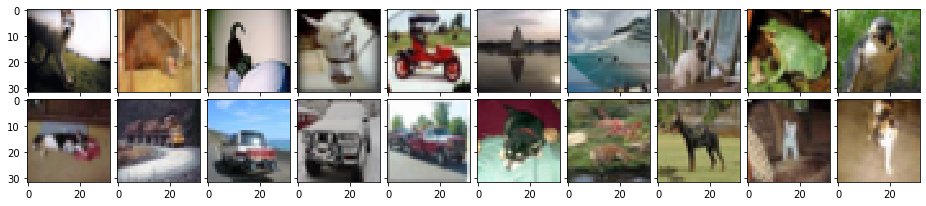

In [93]:
df_wrn_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [94]:
df_wrn_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.995518      0.000265   3762.125488                   3   
1         0.994562      0.000225   4424.791504                   3   
2         0.997089      0.000196   5077.148438                   2   
3         0.999023      0.000196   5107.759277                   5   
4         0.998923      0.000191   5243.682617                   9   
5         0.999607      0.000187   5342.721680                   0   
6         0.999690      0.000183   5462.998047                   0   
7         0.999728      0.000168   5936.280762                   5   
8         0.999142      0.000160   6236.280273                   6   
9         0.999551      0.000152   6564.255371                   5   
10        0.999379      0.000124   8069.060059                   5   
11        0.999623      0.000123   8101.236328                   8   
12        0.999544      0.000099  10106.469727                   9   
13        0.999744      0.000097  10310.932617                   1   
14        0.999645      0.000090  11066.248047                   9   
15        0.999858      0.000069  14408.904297                   3   
16        0.999573      0.000060  16777.896484                   4   
17        0.999670      0.000060  16792.460938                   7   
18        0.999767      0.000051  19422.462891                   3   
19        0.999861      0.000049  20589.728516                   5   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       3059  
1              cat              7            horse       6151  
2             bird              5              dog        810  
3              dog              7            horse       2895  
4            truck              1       automobile       1969  
5         airplane              8             ship       5548  
6         airplane              8             ship        665  
7              dog              3              cat       4614  
8             frog              3              cat       2405  
9              dog              2             bird        384  
10             dog              3              cat       7509  
11            ship              9            truck       2495  
12           truck              1       automobile       7311  
13      automobile              9            truck       4276  
14           truck              1       automobile       9227  
15             cat              5              dog        128  
16            deer              3              cat       4965  
17           horse              5              dog       1506  
18             cat              5              dog       4740  
19             dog              3              cat       7099

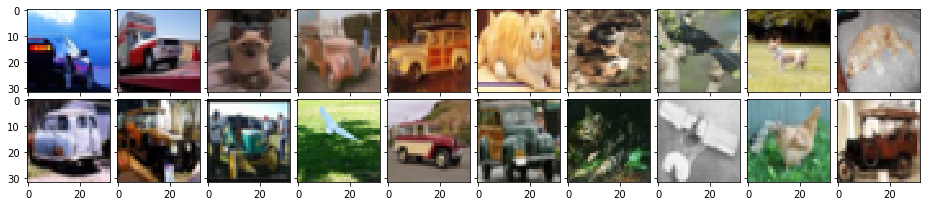

In [95]:
df_wrn_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [96]:
df_wrn_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.998249      0.000777   1285.422852                   0   
1         0.998971      0.000741   1347.244019                   1   
2         0.998506      0.000646   1544.983765                   3   
3         0.995936      0.000539   1847.855225                   9   
4         0.998563      0.000470   2125.257568                   9   
5         0.998716      0.000446   2237.118896                   5   
6         0.999167      0.000437   2286.743164                   5   
7         0.998615      0.000436   2289.148438                   0   
8         0.999127      0.000311   3216.876465                   4   
9         0.998036      0.000298   3349.983398                   3   
10        0.999247      0.000279   3577.541748                   9   
11        0.999511      0.000202   4940.809082                   9   
12        0.999120      0.000200   4988.743652                   9   
13        0.999452      0.000174   5730.492676                   0   
14        0.999467      0.000168   5963.647461                   9   
15        0.999508      0.000166   6026.285645                   9   
16        0.999270      0.000154   6509.142578                   6   
17        0.998479      0.000123   8116.224609                   3   
18        0.999067      0.000117   8505.284180                   3   
19        0.999649      0.000058  17378.416016                   9   

   label_predicted  correct_label correct_label_id  img_index  
0         airplane              1       automobile        300  
1       automobile              9            truck       1838  
2              cat              5              dog       1177  
3            truck              1       automobile        341  
4            truck              1       automobile        390  
5              dog              3              cat        602  
6              dog              3              cat        783  
7         airplane              2             bird        506  
8             deer              5              dog       1076  
9              cat              5              dog       1134  
10           truck              1       automobile        352  
11           truck              1       automobile        344  
12           truck              1       automobile        379  
13        airplane              2             bird        577  
14           truck              1       automobile        254  
15           truck              1       automobile        392  
16            frog              3              cat        739  
17             cat              0         airplane        124  
18             cat              2             bird        592  
19           truck              1       automobile        391

### wrn RA(1,20)

In [97]:
output = search_path + 'wrn_28_10_ra_1_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9463
 -> Sanity Check: 9463 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.953327  0.9600  0.956652   1000.0000
1 automobile   0.968317  0.9780  0.973134   1000.0000
2 bird         0.940162  0.9270  0.933535   1000.0000
3 cat          0.898536  0.8590  0.878323   1000.0000
4  deer        0.950397  0.9580  0.954183   1000.0000
5 dog          0.886700  0.9000  0.893300   1000.0000
6 frog         0.957635  0.9720  0.964764   1000.0000
7 horse        0.968969  0.9680  0.968484   1000.0000
8 ship         0.969124  0.9730  0.971058   1000.0000
9 truck        0.968000  0.9680  0.968000   1000.0000
accuracy       0.946300  0.9463  0.946300      0.9463
macro avg      0.946117  0.9463  0.946143  10000.0000
weighted avg   0.946117  0.9463  0.946143  10000.0000


In [98]:
output = search_path + 'wrn_28_10_ra_1_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8905
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.888889  0.8800  0.884422   200.0000
1 automobile   0.963855  0.8000  0.874317   200.0000
2 bird         0.916230  0.8750  0.895141   200.0000
3 cat          0.826531  0.8100  0.818182   200.0000
4  deer        0.903846  0.9400  0.921569   200.0000
5 dog          0.872449  0.8550  0.863636   200.0000
6 frog         0.894231  0.9300  0.911765   200.0000
7 horse        0.934343  0.9250  0.929648   200.0000
8 ship         0.907767  0.9350  0.921182   200.0000
9 truck        0.819742  0.9550  0.882217   200.0000
accuracy       0.890500  0.8905  0.890500     0.8905
macro avg      0.892788  0.8905  0.890208  2000.0000
weighted avg   0.892788  0.8905  0.890208  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


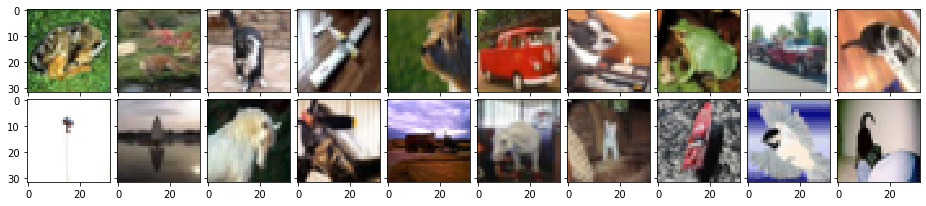

In [99]:
df_wrn_28_10_ra_1_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [100]:
df_wrn_28_10_ra_1_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.998655      0.000144   6924.090820                   6   
1         0.999177      0.000133   7529.847168                   4   
2         0.999619      0.000126   7927.833008                   5   
3         0.998449      0.000123   8143.227539                   2   
4         0.998636      0.000122   8215.466797                   6   
5         0.999480      0.000122   8223.769531                   1   
6         0.998685      0.000121   8226.812500                   3   
7         0.999254      0.000121   8256.356445                   6   
8         0.999443      0.000103   9675.737305                   9   
9         0.999616      0.000103   9693.387695                   5   
10        0.999377      0.000093  10757.008789                   2   
11        0.999422      0.000088  11390.285156                   0   
12        0.999602      0.000071  14171.802734                   5   
13        0.999279      0.000059  16796.724609                   3   
14        0.999579      0.000053  18772.871094                   0   
15        0.999788      0.000042  23621.892578                   5   
16        0.999659      0.000042  23655.437500                   3   
17        0.999782      0.000028  36140.097656                   2   
18        0.999815      0.000026  38108.554688                   0   
19        0.999392      0.000016  62759.292969                   2   

   label_predicted  correct_label correct_label_id  img_index  
0             frog              4             deer       2128  
1             deer              3              cat       4965  
2              dog              3              cat       1163  
3             bird              0         airplane       3601  
4             frog              5              dog       7941  
5       automobile              9            truck       1732  
6              cat              5              dog       9225  
7             frog              3              cat       2405  
8            truck              1       automobile       9227  
9              dog              3              cat       9819  
10            bird              0         airplane       3444  
11        airplane              8             ship       5548  
12             dog              7            horse       9254  
13             cat              0         airplane       2232  
14        airplane              9            truck       3957  
15             dog              7            horse       9587  
16             cat              5              dog       4740  
17            bird              8             ship       1685  
18        airplane              2             bird       8576  
19            bird              5              dog        810

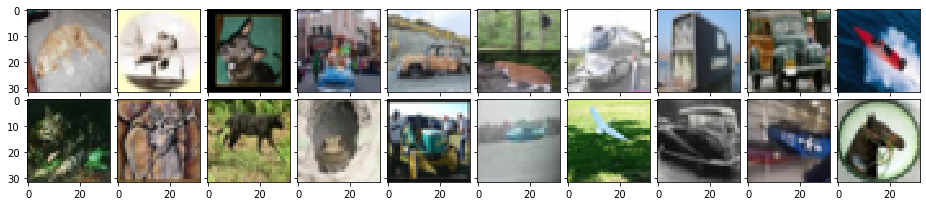

In [101]:
df_wrn_28_10_ra_1_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [102]:
df_wrn_28_10_ra_1_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.998933      0.000241   4143.701660                   3   
1         0.998340      0.000231   4321.038574                   8   
2         0.999319      0.000214   4667.035645                   3   
3         0.999344      0.000205   4874.866211                   9   
4         0.999204      0.000205   4876.926270                   9   
5         0.994717      0.000191   5198.937500                   4   
6         0.998103      0.000186   5355.591309                   0   
7         0.999104      0.000180   5540.571777                   9   
8         0.999307      0.000172   5821.490234                   9   
9         0.999160      0.000153   6534.113770                   0   
10        0.999106      0.000146   6822.725586                   6   
11        0.997362      0.000144   6909.196777                   3   
12        0.998415      0.000143   6964.661133                   4   
13        0.999234      0.000104   9628.810547                   3   
14        0.999648      0.000094  10685.314453                   9   
15        0.999403      0.000091  10927.522461                   8   
16        0.999306      0.000073  13670.819336                   0   
17        0.999797      0.000062  16176.036133                   8   
18        0.999884      0.000027  36375.781250                   8   
19        0.999339      0.000014  70482.203125                   3   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       1134  
1             ship              0         airplane        136  
2              cat              5              dog       1126  
3            truck              1       automobile        381  
4            truck              1       automobile        265  
5             deer              3              cat        699  
6         airplane              9            truck       1872  
7            truck              8             ship       1761  
8            truck              1       automobile        392  
9         airplane              8             ship       1658  
10            frog              3              cat        739  
11             cat              4             deer        926  
12            deer              3              cat        743  
13             cat              6             frog       1217  
14           truck              1       automobile        379  
15            ship              0         airplane        177  
16        airplane              2             bird        577  
17            ship              1       automobile        358  
18            ship              0         airplane        131  
19             cat              7            horse       1412

### wrn_28_10, RA(2,5)

In [103]:
output = search_path + 'wrn_28_10_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9403
 -> Sanity Check: 9403 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.941061  0.9580  0.949455   1000.0000
1 automobile   0.978894  0.9740  0.976441   1000.0000
2 bird         0.946429  0.9010  0.923156   1000.0000
3 cat          0.869960  0.8630  0.866466   1000.0000
4  deer        0.935294  0.9540  0.944554   1000.0000
5 dog          0.885035  0.8930  0.889000   1000.0000
6 frog         0.944063  0.9620  0.952947   1000.0000
7 horse        0.972837  0.9670  0.969910   1000.0000
8 ship         0.955709  0.9710  0.963294   1000.0000
9 truck        0.974619  0.9600  0.967254   1000.0000
accuracy       0.940300  0.9403  0.940300      0.9403
macro avg      0.940390  0.9403  0.940248  10000.0000
weighted avg   0.940390  0.9403  0.940248  10000.0000


In [104]:
output = search_path + 'wrn_28_10_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.852
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.820000   0.820  0.820000   200.000
1 automobile   0.975309   0.790  0.872928   200.000
2 bird         0.872340   0.820  0.845361   200.000
3 cat          0.755000   0.755  0.755000   200.000
4  deer        0.857820   0.905  0.880779   200.000
5 dog          0.844560   0.815  0.829517   200.000
6 frog         0.891089   0.900  0.895522   200.000
7 horse        0.911458   0.875  0.892857   200.000
8 ship         0.845070   0.900  0.871671   200.000
9 truck        0.786611   0.940  0.856492   200.000
accuracy       0.852000   0.852  0.852000     0.852
macro avg      0.855926   0.852  0.852013  2000.000
weighted avg   0.855926   0.852  0.852013  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


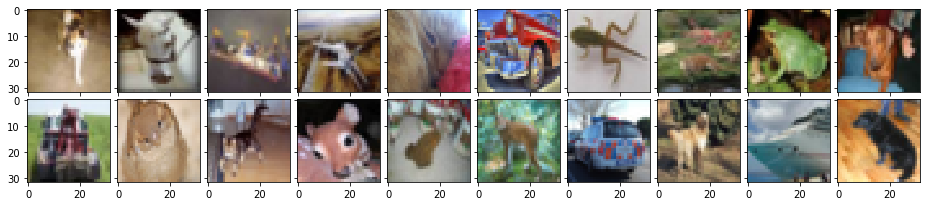

In [105]:
df_wrn_28_10_ra_2_5_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [106]:
df_wrn_28_10_ra_2_5_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999435      0.000123   8112.354004                   5   
1         0.999335      0.000108   9229.202148                   5   
2         0.999107      0.000108   9265.864258                   6   
3         0.999546      0.000099  10141.971680                   4   
4         0.999422      0.000096  10436.019531                   4   
5         0.999766      0.000088  11321.538086                   9   
6         0.998814      0.000087  11443.451172                   0   
7         0.999244      0.000087  11486.103516                   4   
8         0.999167      0.000084  11829.608398                   6   
9         0.999664      0.000080  12511.045898                   3   
10        0.999554      0.000078  12789.964844                   8   
11        0.999413      0.000072  13879.416016                   3   
12        0.999396      0.000064  15719.822266                   7   
13        0.999614      0.000061  16346.745117                   3   
14        0.999774      0.000060  16598.058594                   3   
15        0.999578      0.000055  18159.353516                   5   
16        0.999750      0.000043  23277.033203                   9   
17        0.999690      0.000041  24105.417969                   4   
18        0.999886      0.000035  28231.826172                   0   
19        0.999923      0.000032  31266.000000                   3   

   label_predicted  correct_label correct_label_id  img_index  
0              dog              3              cat       7099  
1              dog              7            horse       2895  
2             frog              8             ship       5398  
3             deer              0         airplane       3097  
4             deer              3              cat        916  
5            truck              1       automobile       7892  
6         airplane              6             frog       8573  
7             deer              3              cat       4965  
8             frog              3              cat       2405  
9              cat              5              dog       8410  
10            ship              9            truck        213  
11             cat              2             bird       7761  
12           horse              3              cat       4485  
13             cat              4             deer       4112  
14             cat              6             frog         59  
15             dog              4             deer       8354  
16           truck              1       automobile       1131  
17            deer              5              dog       4528  
18        airplane              8             ship        665  
19             cat              5              dog       3236

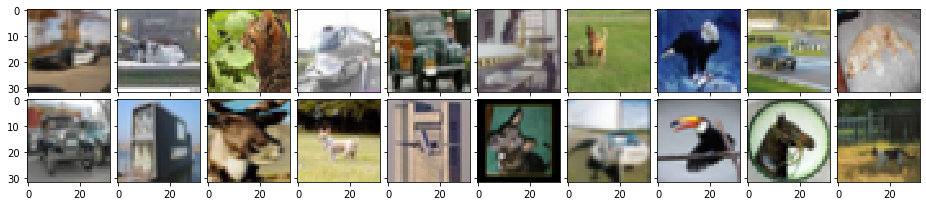

In [107]:
df_wrn_28_10_ra_2_5_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [108]:
df_wrn_28_10_ra_2_5_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.998205      0.000259   3857.569336                   9   
1         0.998282      0.000241   4144.298828                   8   
2         0.998585      0.000236   4233.838867                   6   
3         0.998519      0.000233   4276.562012                   0   
4         0.998939      0.000223   4475.618164                   9   
5         0.996132      0.000207   4812.640137                   9   
6         0.999173      0.000206   4860.127930                   4   
7         0.998150      0.000198   5042.285156                   3   
8         0.999206      0.000190   5269.535156                   0   
9         0.999467      0.000158   6315.770020                   3   
10        0.999487      0.000152   6581.430664                   9   
11        0.999059      0.000138   7259.520508                   9   
12        0.999715      0.000132   7565.419434                   5   
13        0.999048      0.000109   9134.328125                   4   
14        0.994390      0.000093  10699.468750                   3   
15        0.999658      0.000057  17405.384766                   3   
16        0.999688      0.000056  17882.626953                   0   
17        0.999791      0.000036  27520.111328                   0   
18        0.999366      0.000032  31420.626953                   3   
19        0.999840      0.000029  34560.812500                   4   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        369  
1             ship              0         airplane        182  
2             frog              3              cat        605  
3         airplane              9            truck       1872  
4            truck              1       automobile        392  
5            truck              0         airplane        108  
6             deer              5              dog       1162  
7              cat              2             bird        581  
8         airplane              1       automobile        353  
9              cat              5              dog       1134  
10           truck              1       automobile        277  
11           truck              8             ship       1761  
12             dog              4             deer        996  
13            deer              5              dog       1076  
14             cat              0         airplane         98  
15             cat              5              dog       1126  
16        airplane              8             ship       1753  
17        airplane              2             bird        419  
18             cat              7            horse       1412  
19            deer              3              cat        772

### wrn_28_10, RA(2,20)

In [109]:
output = search_path + 'wrn_28_10_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9315
 -> Sanity Check: 9315 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.943057  0.9440  0.943528   1000.0000
1 automobile   0.964965  0.9640  0.964482   1000.0000
2 bird         0.910256  0.9230  0.916584   1000.0000
3 cat          0.884868  0.8070  0.844142   1000.0000
4  deer        0.897363  0.9530  0.924345   1000.0000
5 dog          0.875124  0.8830  0.879044   1000.0000
6 frog         0.945152  0.9650  0.954973   1000.0000
7 horse        0.973388  0.9510  0.962064   1000.0000
8 ship         0.963928  0.9620  0.962963   1000.0000
9 truck        0.956306  0.9630  0.959641   1000.0000
accuracy       0.931500  0.9315  0.931500      0.9315
macro avg      0.931441  0.9315  0.931177  10000.0000
weighted avg   0.931441  0.9315  0.931177  10000.0000


In [110]:
output = search_path + 'wrn_28_10_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.847
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.850515   0.825  0.837563   200.000
1 automobile   0.928571   0.780  0.847826   200.000
2 bird         0.843137   0.860  0.851485   200.000
3 cat          0.764398   0.730  0.746803   200.000
4  deer        0.807339   0.880  0.842105   200.000
5 dog          0.812183   0.800  0.806045   200.000
6 frog         0.878049   0.900  0.888889   200.000
7 horse        0.907692   0.885  0.896203   200.000
8 ship         0.907692   0.885  0.896203   200.000
9 truck        0.793991   0.925  0.854503   200.000
accuracy       0.847000   0.847  0.847000     0.847
macro avg      0.849357   0.847  0.846763  2000.000
weighted avg   0.849357   0.847  0.846763  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


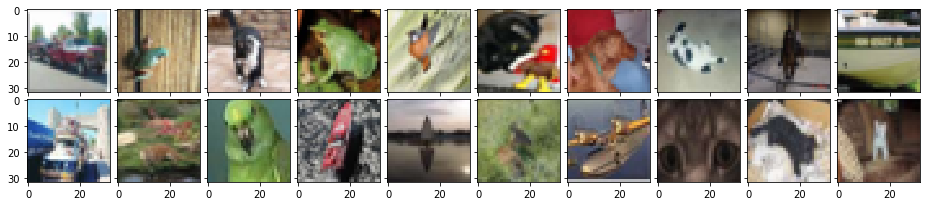

In [111]:
df_wrn_28_10_ra_2_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [112]:
df_wrn_28_10_ra_2_20_errors

prob_predicted  prob_correct        r_value  label_predicted_id  \
0         0.999611      0.000072   13824.489258                   9   
1         0.996567      0.000070   14317.442383                   2   
2         0.999573      0.000057   17452.824219                   5   
3         0.999566      0.000055   18231.906250                   6   
4         0.999850      0.000054   18463.712891                   6   
5         0.999705      0.000054   18529.562500                   5   
6         0.999883      0.000053   18784.687500                   3   
7         0.999659      0.000053   18866.865234                   5   
8         0.998825      0.000038   26262.482422                   0   
9         0.999695      0.000038   26474.572266                   0   
10        0.999861      0.000036   27932.146484                   8   
11        0.999609      0.000034   29576.347656                   4   
12        0.999302      0.000033   30158.705078                   3   
13        0.999632      0.000028   36250.867188                   2   
14        0.999801      0.000027   37591.152344                   0   
15        0.999754      0.000022   46088.093750                   2   
16        0.999952      0.000010   96593.414062                   8   
17        0.999988      0.000009  111599.742188                   5   
18        0.999960      0.000005  187470.468750                   3   
19        0.999980      0.000002  525518.750000                   3   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile       9227  
1             bird              6             frog       1935  
2              dog              3              cat       1163  
3             frog              3              cat       2405  
4             frog              2             bird       2675  
5              dog              3              cat       2779  
6              cat              5              dog        158  
7              dog              3              cat       2350  
8         airplane              7            horse       6631  
9         airplane              8             ship        683  
10            ship              9            truck       2271  
11            deer              3              cat       4965  
12             cat              2             bird       7107  
13            bird              8             ship       1685  
14        airplane              8             ship       5548  
15            bird              4             deer       9386  
16            ship              0         airplane       2248  
17             dog              3              cat       3084  
18             cat              5              dog        275  
19             cat              5              dog       4740

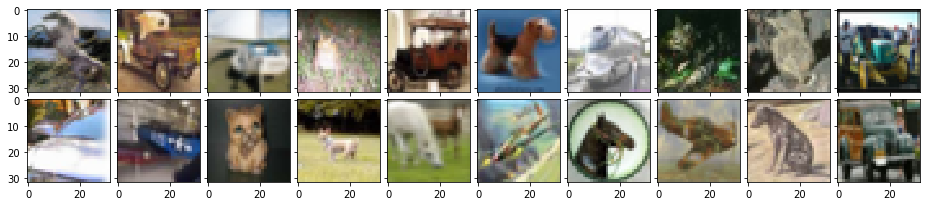

In [113]:
df_wrn_28_10_ra_2_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [114]:
df_wrn_28_10_ra_2_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.990729      0.000263   3760.246338                   3   
1         0.999461      0.000251   3984.932373                   9   
2         0.997556      0.000247   4043.453125                   0   
3         0.999356      0.000245   4079.575684                   4   
4         0.998879      0.000239   4173.080078                   9   
5         0.997308      0.000233   4280.050293                   3   
6         0.996258      0.000202   4924.016113                   0   
7         0.999108      0.000189   5284.491699                   6   
8         0.999347      0.000165   6061.375488                   6   
9         0.999013      0.000163   6135.445801                   9   
10        0.998046      0.000149   6695.479004                   2   
11        0.999529      0.000146   6863.945801                   8   
12        0.999637      0.000107   9343.070312                   5   
13        0.999504      0.000095  10572.708008                   4   
14        0.999566      0.000092  10920.688477                   4   
15        0.991818      0.000085  11611.305664                   6   
16        0.998752      0.000054  18655.007812                   3   
17        0.997014      0.000048  20636.119141                   6   
18        0.999405      0.000030  32929.035156                   3   
19        0.999900      0.000022  45529.214844                   9   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              7            horse       1528  
1            truck              1       automobile        336  
2         airplane              8             ship       1753  
3             deer              6             frog       1344  
4            truck              1       automobile        391  
5              cat              5              dog       1146  
6         airplane              9            truck       1872  
7             frog              3              cat        739  
8             frog              2             bird        515  
9            truck              1       automobile        379  
10            bird              1       automobile        304  
11            ship              0         airplane        131  
12             dog              3              cat        757  
13            deer              5              dog       1076  
14            deer              7            horse       1419  
15            frog              0         airplane         87  
16             cat              7            horse       1412  
17            frog              0         airplane        199  
18             cat              5              dog       1148  
19           truck              1       automobile        392

### wrn_28_10, RA(3,20)

In [115]:
output = search_path + 'wrn_28_10_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9001
 -> Sanity Check: 9001 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.909633  0.9160  0.912805   1000.0000
1 automobile   0.941406  0.9640  0.952569   1000.0000
2 bird         0.878788  0.8700  0.874372   1000.0000
3 cat          0.795025  0.7990  0.797007   1000.0000
4  deer        0.882066  0.9050  0.893386   1000.0000
5 dog          0.854639  0.8290  0.841624   1000.0000
6 frog         0.915370  0.9410  0.928008   1000.0000
7 horse        0.928571  0.9100  0.919192   1000.0000
8 ship         0.947154  0.9320  0.939516   1000.0000
9 truck        0.948276  0.9350  0.941591   1000.0000
accuracy       0.900100  0.9001  0.900100      0.9001
macro avg      0.900093  0.9001  0.900007  10000.0000
weighted avg   0.900093  0.9001  0.900007  10000.0000


In [116]:
output = search_path + 'wrn_28_10_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.798
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.772727   0.765  0.768844   200.000
1 automobile   0.893491   0.755  0.818428   200.000
2 bird         0.776119   0.780  0.778055   200.000
3 cat          0.677725   0.715  0.695864   200.000
4  deer        0.777778   0.840  0.807692   200.000
5 dog          0.772277   0.780  0.776119   200.000
6 frog         0.841584   0.850  0.845771   200.000
7 horse        0.903409   0.795  0.845745   200.000
8 ship         0.825641   0.805  0.815190   200.000
9 truck        0.778261   0.895  0.832558   200.000
accuracy       0.798000   0.798  0.798000     0.798
macro avg      0.801901   0.798  0.798427  2000.000
weighted avg   0.801901   0.798  0.798427  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


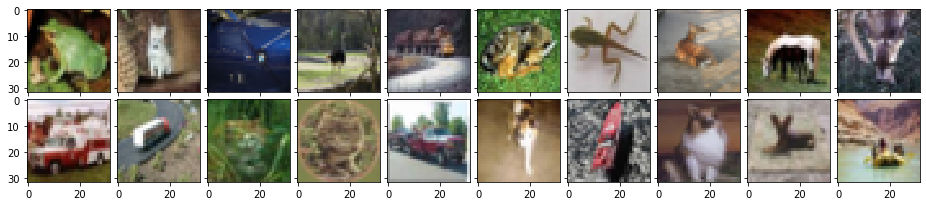

In [117]:
df_wrn_28_10_ra_3_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [118]:
df_wrn_28_10_ra_3_20_errors

prob_predicted  prob_correct      r_value  label_predicted_id  \
0         0.994427      0.001140   872.003540                   6   
1         0.995187      0.001130   880.931580                   3   
2         0.988764      0.001076   918.807190                   0   
3         0.996933      0.001010   987.120483                   4   
4         0.995052      0.000984  1010.844116                   8   
5         0.996960      0.000958  1040.760620                   6   
6         0.987723      0.000940  1051.141113                   0   
7         0.988193      0.000935  1057.454834                   3   
8         0.993246      0.000776  1280.566650                   4   
9         0.996765      0.000602  1655.688110                   2   
10        0.997000      0.000559  1782.790649                   9   
11        0.977731      0.000537  1820.547607                   2   
12        0.996113      0.000546  1824.112915                   6   
13        0.996649      0.000530  1879.758179                   6   
14        0.997415      0.000504  1979.949219                   9   
15        0.998448      0.000480  2081.043213                   5   
16        0.996807      0.000348  2861.235352                   2   
17        0.999344      0.000268  3724.307617                   3   
18        0.997233      0.000263  3796.922607                   4   
19        0.996620      0.000261  3813.779785                   4   

   label_predicted  correct_label correct_label_id  img_index  
0             frog              3              cat       2405  
1              cat              5              dog       4906  
2         airplane              1       automobile       4055  
3             deer              2             bird       7906  
4             ship              9            truck       2495  
5             frog              4             deer       2128  
6         airplane              6             frog       8573  
7              cat              4             deer       3696  
8             deer              7            horse       5677  
9             bird              4             deer       1393  
10           truck              1       automobile       3560  
11            bird              9            truck       4590  
12            frog              3              cat       3977  
13            frog              3              cat       5511  
14           truck              1       automobile       9227  
15             dog              3              cat       7099  
16            bird              8             ship       1685  
17             cat              5              dog       5426  
18            deer              5              dog       3192  
19            deer              8             ship       8757

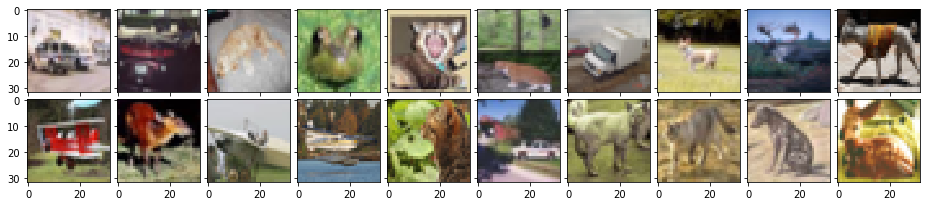

In [119]:
df_wrn_28_10_ra_3_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [120]:
df_wrn_28_10_ra_3_20_errors_101

prob_predicted  prob_correct      r_value  label_predicted_id  \
0         0.991921      0.002160   459.137909                   9   
1         0.990231      0.002129   465.009094                   0   
2         0.991704      0.002043   485.420319                   3   
3         0.979118      0.001915   511.215210                   2   
4         0.989455      0.001813   545.708740                   4   
5         0.930468      0.001694   549.384583                   4   
6         0.993542      0.001575   630.727051                   8   
7         0.981260      0.001492   657.621399                   4   
8         0.984591      0.001493   659.576965                   0   
9         0.992387      0.001449   684.732666                   7   
10        0.992970      0.001281   775.217346                   9   
11        0.989699      0.001234   801.843933                   6   
12        0.993484      0.001158   858.073914                   4   
13        0.996338      0.000816  1220.367554                   8   
14        0.992492      0.000787  1260.502808                   6   
15        0.993626      0.000702  1415.186035                   0   
16        0.979737      0.000619  1582.439819                   7   
17        0.996961      0.000450  2213.914307                   4   
18        0.995457      0.000366  2718.745117                   3   
19        0.995586      0.000237  4195.333984                   6   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        368  
1         airplane              1       automobile        308  
2              cat              5              dog       1134  
3             bird              6             frog       1361  
4             deer              3              cat        630  
5             deer              3              cat        699  
6             ship              9            truck       1947  
7             deer              5              dog       1076  
8         airplane              4             deer        952  
9            horse              5              dog       1121  
10           truck              0         airplane        171  
11            frog              4             deer        866  
12            deer              0         airplane        119  
13            ship              0         airplane        187  
14            frog              3              cat        605  
15        airplane              1       automobile        365  
16           horse              3              cat        641  
17            deer              3              cat        680  
18             cat              5              dog       1148  
19            frog              4             deer        861

### compare all wrn

The number of common misclassifications across all models: 1
{2405}


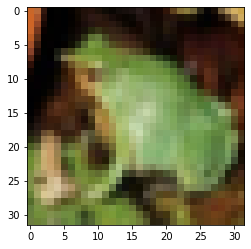

In [121]:
# View intersection of errors
#change the intersect
intersect = set(df_wrn_errors.img_index) & \
            set(df_wrn_28_10_ra_1_20_errors.img_index) & \
            set(df_wrn_28_10_ra_2_5_errors.img_index) & \
            set(df_wrn_28_10_ra_2_20_errors.img_index) & \
            set(df_wrn_28_10_ra_3_20_errors.img_index)

print("The number of common misclassifications across all models:", len(intersect))
print(intersect)

images_to_print = []

for i in intersect:
    img=Image.fromarray(test_data_CIFAR10[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [122]:
df = pd.DataFrame()

# change these labels

# intersect = set(df_resnet32_errors.img_index) & \
#             set(df_resnet32_errors_ra_2_5.img_index) & \
#             set(df_resnet32_errors_ra_2_20.img_index) & \
#             set(df_resnet32_errors_ra_3_20.img_index)

for m, me in [('wrn', df_wrn_errors.img_index),
              ('wrn_ra_1_20', df_wrn_28_10_ra_1_20_errors.img_index),
              ('wrn_ra_2_5', df_wrn_28_10_ra_2_5_errors.img_index), 
              ('wrn_ra_2_20', df_wrn_28_10_ra_2_20_errors.img_index), 
              ('wrn_ra_3_20', df_wrn_28_10_ra_3_20_errors.img_index)]:
    for e in me:
        df.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df.fillna(False, inplace=True)
cols = df.columns
df.reset_index(inplace=True)
df

index   3059   6151    810   2895   1969   5548    665   4614  2405  \
0          wrn   True   True   True   True   True   True   True   True  True   
1  wrn_ra_1_20  False  False   True  False  False   True  False  False  True   
2   wrn_ra_2_5  False  False  False   True  False  False   True  False  True   
3  wrn_ra_2_20  False  False  False  False  False   True  False  False  True   
4  wrn_ra_3_20  False  False  False  False  False  False  False  False  True   

     384   7509   2495   7311   4276   9227    128   4965   1506   4740  \
0   True   True   True   True   True   True   True   True   True   True   
1  False  False  False  False  False   True  False   True  False   True   
2  False  False  False  False  False  False  False   True  False  False   
3  False  False  False  False  False   True  False   True  False   True   
4  False  False   True  False  False   True  False  False  False  False   

    7099   2128   1163   3601   7941   1732   9225   9819   3444   9254  \
0   True  False  False  False  False  False  False  False  False  False   
1  False   True   True   True   True   True   True   True   True   True   
2   True  False  False  False  False  False  False  False  False  False   
3  False  False   True  False  False  False  False  False  False  False   
4   True   True  False  False  False  False  False  False  False  False   

    2232   3957   9587   1685   8576   5398   3097    916   7892   8573  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True  False  False  False  False  False   
2  False  False  False  False  False   True   True   True   True   True   
3  False  False  False   True  False  False  False  False  False  False   
4  False  False  False   True  False  False  False  False  False   True   

    8410    213   7761   4485   4112     59   8354   1131   4528   3236  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True   True   True   True   
3  False  False  False  False  False  False  False  False  False  False   
4  False  False  False  False  False  False  False  False  False  False   

    1935   2675   2779    158   2350   6631    683   2271   7107   9386  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True   True   True   True   True   True   True   True   
4  False  False  False  False  False  False  False  False  False  False   

    2248   3084    275   4906   4055   7906   3696   5677   1393   3560  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True  False  False  False  False  False  False  False   
4  False  False  False   True   True   True   True   True   True   True   

    4590   3977   5511   5426   3192   8757  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4   True   True   True   True   True   True

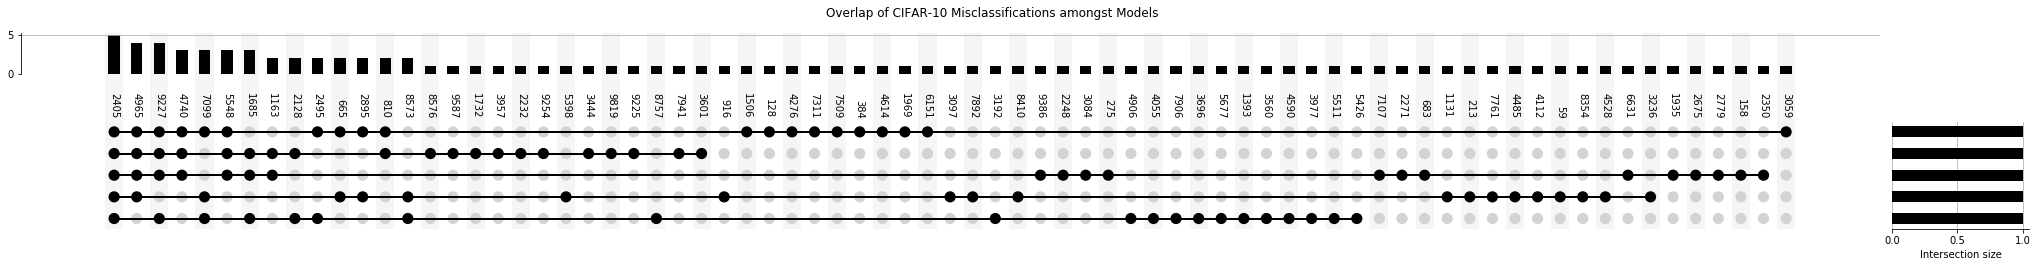

In [123]:
overlap = df.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show()  

In [124]:
# View intersection of errors
intersect101 = set(df_wrn_errors_101.img_index) & \
            set(df_wrn_28_10_ra_1_20_errors_101.img_index) & \
            set(df_wrn_28_10_ra_2_5_errors_101.img_index) & \
            set(df_wrn_28_10_ra_2_20_errors_101.img_index) & \
            set(df_wrn_28_10_ra_3_20_errors_101.img_index)

            
print("The number of common misclassifications across all models:", len(intersect101))
print(intersect101)

# View errors 
# df_errors_101 = pd.DataFrame({'resnext_29_4x64' : df_resnext4_errors_101.img_index,
#                              'resnext_29_8x64' : df_resnext8_errors_101.img_index,
#                              'resnet32' : df_resnet32_errors_101.img_index,
#                              'densenet' : df_densenet_errors_101.img_index,
#                              'wrn_28_10' : df_wrn_28_10_errors_101.img_index,
#                              'pyramidnet_basic_110_84' : df_pyramidnet_basic_110_84_errors_101.img_index,
#                              'resnet44' : df_resnet44_errors.img_index})

images_to_print = []

for i in intersect101:
    img=Image.fromarray(test_data_CIFAR101[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect101)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

The number of common misclassifications across all models: 0
set()


IndexError: list index out of range

<Figure size 1152x288 with 0 Axes>

In [125]:
df101 = pd.DataFrame()

for m, me in [('wrn', df_wrn_errors_101.img_index), 
              ('wrn_ra_1_20', df_wrn_28_10_ra_1_20_errors_101.img_index), 
              ('wrn_ra_2_5', df_wrn_28_10_ra_2_5_errors_101.img_index), 
              ('wrn_ra_2_20', df_wrn_28_10_ra_2_20_errors_101.img_index), 
              ('wrn_ra_3_20', df_wrn_28_10_ra_3_20_errors_101.img_index)]:
    for e in me:
        df101.loc[m, str(e)] = True

pd.options.display.max_rows = None
pd.options.display.max_columns = None
df101.fillna(False, inplace=True)
cols = df101.columns
df101.reset_index(inplace=True)
df101

index    300   1838   1177    341    390    602    783    506   1076  \
0          wrn   True   True   True   True   True   True   True   True   True   
1  wrn_ra_1_20  False  False  False  False  False  False  False  False  False   
2   wrn_ra_2_5  False  False  False  False  False  False  False  False   True   
3  wrn_ra_2_20  False  False  False  False  False  False  False  False   True   
4  wrn_ra_3_20  False  False  False  False  False  False  False  False   True   

    1134    352    344    379    577    254    392    739    124    592  \
0   True   True   True   True   True   True   True   True   True   True   
1   True  False  False   True   True  False   True   True  False  False   
2   True  False  False  False  False  False   True  False  False  False   
3  False  False  False   True  False  False   True   True  False  False   
4   True  False  False  False  False  False  False  False  False  False   

     391    136   1126    381    265    699   1872   1761   1658    926  \
0   True  False  False  False  False  False  False  False  False  False   
1  False   True   True   True   True   True   True   True   True   True   
2  False  False   True  False  False  False   True   True  False  False   
3   True  False  False  False  False  False   True  False  False  False   
4  False  False  False  False  False   True  False  False  False  False   

     743   1217    177    358    131   1412    369    182    605    108  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True  False  False  False  False   
2  False  False  False  False  False   True   True   True   True   True   
3  False  False  False  False   True   True  False  False  False  False   
4  False  False  False  False  False  False  False  False   True  False   

    1162    581    353    277    996     98   1753    419    772   1528  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True   True   True  False   
3  False  False  False  False  False  False   True  False  False   True   
4  False  False  False  False  False  False  False  False  False  False   

     336   1344   1146    515    304    757   1419     87    199   1148  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True   True   True   True   True   True   True   True   
4  False  False  False  False  False  False  False  False  False   True   

     368    308   1361    630   1947    952   1121    171    866    119  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3  False  False  False  False  False  False  False  False  False  False   
4   True   True   True   True   True   True   True   True   True   True   

     187    365    641    680    861  
0  False  False  False  False  False  
1  False  False  False  False  False  
2  False  False  False  False  False  
3  False  False  False  False  False  
4   True   True   True   True   True

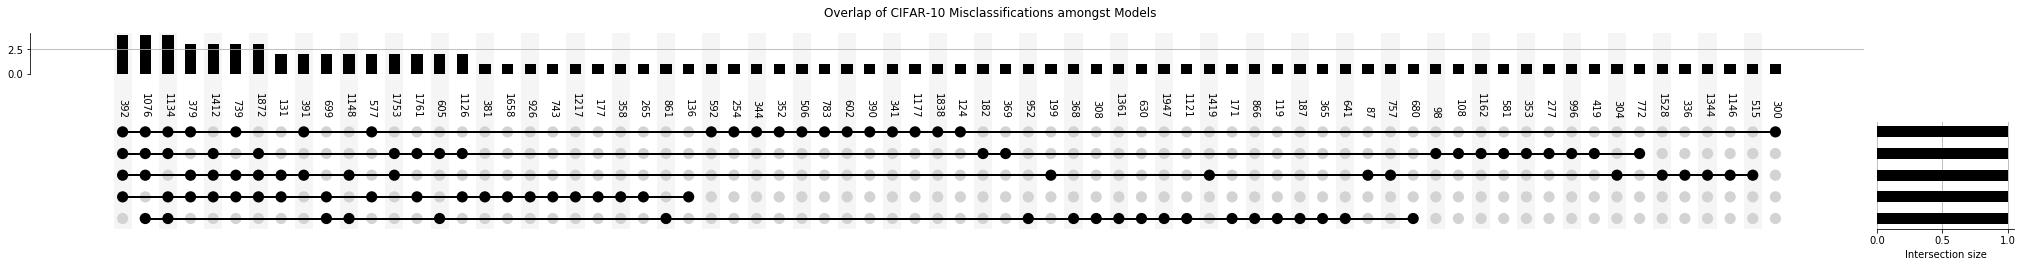

In [126]:
overlap = df101.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show() 

### now densenet

In [127]:
output = search_path + 'densenet_BC_100_12/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9484
 -> Sanity Check: 9484 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.951244  0.9560  0.953616   1000.0000
1 automobile   0.971087  0.9740  0.972541   1000.0000
2 bird         0.955533  0.9240  0.939502   1000.0000
3 cat          0.899288  0.8840  0.891578   1000.0000
4  deer        0.937683  0.9630  0.950173   1000.0000
5 dog          0.898354  0.9280  0.912937   1000.0000
6 frog         0.966000  0.9660  0.966000   1000.0000
7 horse        0.983673  0.9640  0.973737   1000.0000
8 ship         0.954769  0.9710  0.962816   1000.0000
9 truck        0.968528  0.9540  0.961209   1000.0000
accuracy       0.948400  0.9484  0.948400      0.9484
macro avg      0.948616  0.9484  0.948411  10000.0000
weighted avg   0.948616  0.9484  0.948411  10000.0000


In [128]:
output = search_path + 'densenet_BC_100_12/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.883
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.859296   0.855  0.857143   200.000
1 automobile   0.968354   0.765  0.854749   200.000
2 bird         0.873171   0.895  0.883951   200.000
3 cat          0.851064   0.800  0.824742   200.000
4  deer        0.898551   0.930  0.914005   200.000
5 dog          0.864322   0.860  0.862155   200.000
6 frog         0.921182   0.935  0.928040   200.000
7 horse        0.939394   0.930  0.934673   200.000
8 ship         0.858491   0.910  0.883495   200.000
9 truck        0.822511   0.950  0.881671   200.000
accuracy       0.883000   0.883  0.883000     0.883
macro avg      0.885634   0.883  0.882462  2000.000
weighted avg   0.885634   0.883  0.882462  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


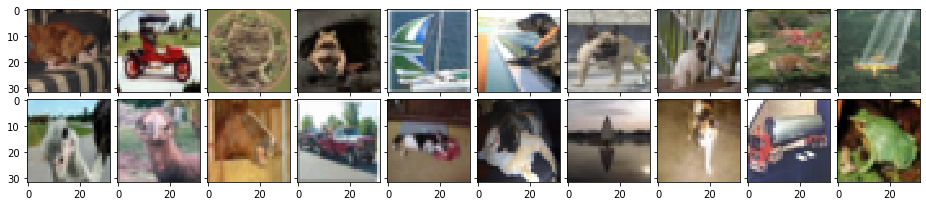

In [129]:
df_densenet_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [130]:
df_densenet_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999986  1.330717e-05  7.514643e+04                   3   
1         0.999588  1.096647e-05  9.114944e+04                   9   
2         0.999925  1.023711e-05  9.767648e+04                   6   
3         0.995281  7.736055e-06  1.286549e+05                   5   
4         0.999388  6.549802e-06  1.525830e+05                   0   
5         0.887884  5.223285e-06  1.699857e+05                   1   
6         0.807098  4.371054e-06  1.846460e+05                   5   
7         0.999940  5.301942e-06  1.885988e+05                   5   
8         0.999968  2.706531e-06  3.694648e+05                   4   
9         0.999197  1.989888e-06  5.021373e+05                   8   
10        0.999782  1.330388e-06  7.514962e+05                   5   
11        0.977794  8.521764e-07  1.147408e+06                   4   
12        0.999749  5.940653e-07  1.682894e+06                   3   
13        0.999999  5.896199e-07  1.696007e+06                   9   
14        0.999909  5.491632e-07  1.820786e+06                   5   
15        1.000000  2.291939e-07  4.363117e+06                   5   
16        1.000000  1.532814e-07  6.523949e+06                   0   
17        1.000000  1.085486e-07  9.212465e+06                   5   
18        1.000000  8.656756e-08  1.155167e+07                   0   
19        0.999938  2.747537e-08  3.639398e+07                   6   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       5830  
1            truck              1       automobile       1969  
2             frog              3              cat       5511  
3              dog              6             frog       8728  
4         airplane              8             ship       1772  
5       automobile              5              dog       2525  
6              dog              3              cat       2804  
7              dog              3              cat       4614  
8             deer              3              cat       4965  
9             ship              0         airplane        378  
10             dog              2             bird       7657  
11            deer              2             bird       2592  
12             cat              7            horse       6151  
13           truck              1       automobile       9227  
14             dog              3              cat       7509  
15             dog              3              cat       9431  
16        airplane              8             ship       5548  
17             dog              3              cat       7099  
18        airplane              9            truck       6741  
19            frog              3              cat       2405

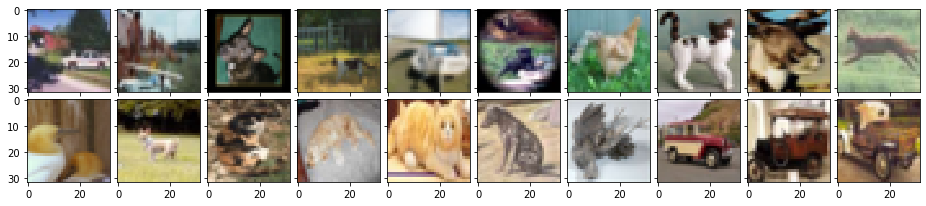

In [131]:
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [132]:
df_densenet_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.965693  1.702146e-04  5.673386e+03                   9   
1         0.985442  1.526594e-04  6.455169e+03                   8   
2         0.999797  1.389711e-04  7.194279e+03                   3   
3         0.994349  1.198931e-04  8.293630e+03                   4   
4         0.996554  1.052018e-04  9.472788e+03                   0   
5         0.905748  8.101539e-05  1.117995e+04                   8   
6         0.992400  6.888977e-05  1.440562e+04                   3   
7         0.999931  6.916542e-05  1.445709e+04                   5   
8         0.999896  5.984369e-05  1.670847e+04                   3   
9         0.928986  4.205892e-05  2.208772e+04                   7   
10        0.979044  2.712986e-05  3.608733e+04                   3   
11        0.998892  2.554665e-05  3.910070e+04                   4   
12        0.999766  1.169858e-05  8.546048e+04                   5   
13        0.999973  5.553322e-06  1.800676e+05                   3   
14        0.999634  4.331972e-06  2.307571e+05                   5   
15        0.998626  4.192331e-06  2.382030e+05                   3   
16        0.999318  3.548552e-06  2.816128e+05                   3   
17        0.999998  1.154429e-06  8.662274e+05                   9   
18        0.999990  1.980956e-07  5.048014e+06                   9   
19        0.999998  1.354108e-07  7.384922e+06                   9   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        365  
1             ship              0         airplane         76  
2              cat              5              dog       1126  
3             deer              3              cat        772  
4         airplane              8             ship       1753  
5             ship              5              dog       1060  
6              cat              2             bird        592  
7              dog              3              cat        600  
8              cat              4             deer        996  
9            horse              3              cat        671  
10             cat              2             bird        420  
11            deer              5              dog       1076  
12             dog              3              cat        783  
13             cat              5              dog       1134  
14             dog              3              cat        602  
15             cat              5              dog       1148  
16             cat              2             bird        433  
17           truck              1       automobile        254  
18           truck              1       automobile        391  
19           truck              1       automobile        336

### densenet, RA(1,20)

In [133]:
output = search_path + 'densenet_BC_100_12_ra_1_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9349
 -> Sanity Check: 9349 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.928780  0.9520  0.940247   1000.0000
1 automobile   0.971859  0.9670  0.969424   1000.0000
2 bird         0.924644  0.9080  0.916246   1000.0000
3 cat          0.854311  0.8620  0.858138   1000.0000
4  deer        0.936946  0.9510  0.943921   1000.0000
5 dog          0.898969  0.8720  0.885279   1000.0000
6 frog         0.946640  0.9580  0.952286   1000.0000
7 horse        0.966463  0.9510  0.958669   1000.0000
8 ship         0.954590  0.9670  0.960755   1000.0000
9 truck        0.965829  0.9610  0.963409   1000.0000
accuracy       0.934900  0.9349  0.934900      0.9349
macro avg      0.934903  0.9349  0.934837  10000.0000
weighted avg   0.934903  0.9349  0.934837  10000.0000


In [134]:
output = search_path + 'densenet_BC_100_12_ra_1_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8605
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.809756  0.8300  0.819753   200.0000
1 automobile   0.950617  0.7700  0.850829   200.0000
2 bird         0.875000  0.8750  0.875000   200.0000
3 cat          0.781095  0.7850  0.783042   200.0000
4  deer        0.885714  0.9300  0.907317   200.0000
5 dog          0.871658  0.8150  0.842377   200.0000
6 frog         0.859155  0.9150  0.886199   200.0000
7 horse        0.925926  0.8750  0.899743   200.0000
8 ship         0.895288  0.8550  0.874680   200.0000
9 truck        0.789256  0.9550  0.864253   200.0000
accuracy       0.860500  0.8605  0.860500     0.8605
macro avg      0.864346  0.8605  0.860319  2000.0000
weighted avg   0.864346  0.8605  0.860319  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


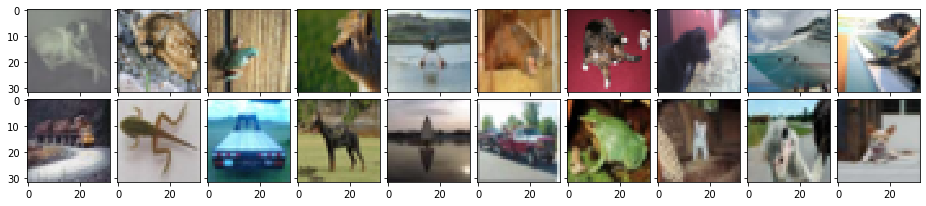

In [135]:
df_densenet_ra_1_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [136]:
df_densenet_ra_1_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999939  1.213884e-05  8.237516e+04                   3   
1         0.997148  1.158175e-05  8.609650e+04                   3   
2         0.634194  7.268642e-06  8.725073e+04                   2   
3         0.986638  1.044702e-05  9.444207e+04                   6   
4         0.996770  9.411666e-06  1.059079e+05                   8   
5         0.685272  4.343275e-06  1.577778e+05                   3   
6         0.999986  3.765367e-06  2.655745e+05                   5   
7         0.940073  3.337998e-06  2.816278e+05                   3   
8         0.999994  2.930551e-06  3.412308e+05                   0   
9         0.721691  1.787174e-06  4.038167e+05                   0   
10        0.999987  2.450264e-06  4.081141e+05                   8   
11        0.999991  1.867097e-06  5.355858e+05                   0   
12        0.997000  1.195747e-06  8.337882e+05                   1   
13        0.999998  4.309308e-07  2.320553e+06                   7   
14        0.999999  1.523446e-07  6.564058e+06                   0   
15        0.999999  1.132687e-07  8.828561e+06                   9   
16        1.000000  3.848982e-08  2.598090e+07                   6   
17        0.999021  3.229926e-08  3.093015e+07                   3   
18        0.999767  1.412964e-08  7.075675e+07                   5   
19        1.000000  1.251129e-08  7.992781e+07                   3   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       8236  
1              cat              4             deer       3753  
2             bird              6             frog       1935  
3             frog              5              dog       7941  
4             ship              0         airplane       3490  
5              cat              7            horse       6151  
6              dog              3              cat       4077  
7              cat              5              dog       7398  
8         airplane              8             ship        665  
9         airplane              5              dog       2525  
10            ship              9            truck       2495  
11        airplane              6             frog       8573  
12      automobile              9            truck       4931  
13           horse              5              dog       1506  
14        airplane              8             ship       5548  
15           truck              1       automobile       9227  
16            frog              3              cat       2405  
17             cat              5              dog       4740  
18             dog              2             bird       7657  
19             cat              5              dog       3202

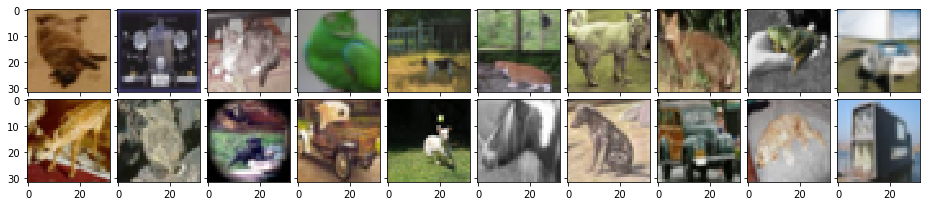

In [137]:
df_densenet_ra_1_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [138]:
df_densenet_ra_1_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.998678  1.066040e-04  9.368106e+03                   2   
1         0.994528  8.821800e-05  1.127353e+04                   9   
2         0.998292  8.592963e-05  1.161755e+04                   5   
3         0.999918  8.056153e-05  1.241186e+04                   6   
4         0.992556  6.625586e-05  1.498065e+04                   4   
5         0.642318  4.108383e-05  1.563433e+04                   2   
6         0.973169  5.706209e-05  1.705456e+04                   7   
7         0.999417  3.933789e-05  2.540596e+04                   4   
8         0.866408  3.353184e-05  2.583836e+04                   3   
9         0.999709  1.997104e-05  5.005793e+04                   0   
10        0.988544  1.248784e-05  7.916052e+04                   6   
11        0.999988  1.102776e-05  9.067916e+04                   6   
12        0.979908  8.017936e-06  1.222144e+05                   3   
13        0.999990  7.201986e-06  1.388492e+05                   9   
14        0.999985  4.749116e-06  2.105623e+05                   7   
15        0.996655  4.327167e-06  2.303251e+05                   0   
16        0.991502  3.964311e-06  2.501072e+05                   3   
17        0.999992  9.891437e-07  1.010967e+06                   9   
18        0.992227  6.046780e-07  1.640918e+06                   3   
19        0.999980  1.694695e-07  5.900652e+06                   9   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              3              cat        720  
1            truck              1       automobile        382  
2              dog              3              cat        692  
3             frog              2             bird        427  
4             deer              3              cat        772  
5             bird              3              cat        699  
6            horse              3              cat        641  
7             deer              3              cat        668  
8              cat              6             frog       1304  
9         airplane              8             ship       1753  
10            frog              4             deer        910  
11            frog              2             bird        515  
12             cat              5              dog       1060  
13           truck              1       automobile        336  
14           horse              5              dog       1088  
15        airplane              7            horse       1585  
16             cat              5              dog       1148  
17           truck              1       automobile        392  
18             cat              5              dog       1134  
19           truck              8             ship       1761

### densenet, RA(2,5)

In [139]:
output = search_path + 'densenet_BC_100_12_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9313
 -> Sanity Check: 9313 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.930898  0.9430  0.936910   1000.0000
1 automobile   0.973843  0.9680  0.970913   1000.0000
2 bird         0.913828  0.9120  0.912913   1000.0000
3 cat          0.872497  0.8280  0.849666   1000.0000
4  deer        0.928571  0.9360  0.932271   1000.0000
5 dog          0.896130  0.8800  0.887992   1000.0000
6 frog         0.936461  0.9580  0.947108   1000.0000
7 horse        0.954092  0.9560  0.955045   1000.0000
8 ship         0.954545  0.9660  0.960239   1000.0000
9 truck        0.947988  0.9660  0.956909   1000.0000
accuracy       0.931300  0.9313  0.931300      0.9313
macro avg      0.930886  0.9313  0.930997  10000.0000
weighted avg   0.930886  0.9313  0.930997  10000.0000


In [140]:
output = search_path + 'densenet_BC_100_12_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.847
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.814634   0.835  0.824691   200.000
1 automobile   0.968153   0.760  0.851541   200.000
2 bird         0.843137   0.860  0.851485   200.000
3 cat          0.779570   0.725  0.751295   200.000
4  deer        0.835681   0.890  0.861985   200.000
5 dog          0.837696   0.800  0.818414   200.000
6 frog         0.884615   0.920  0.901961   200.000
7 horse        0.878049   0.900  0.888889   200.000
8 ship         0.852217   0.865  0.858561   200.000
9 truck        0.802632   0.915  0.855140   200.000
accuracy       0.847000   0.847  0.847000     0.847
macro avg      0.849638   0.847  0.846396  2000.000
weighted avg   0.849638   0.847  0.846396  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


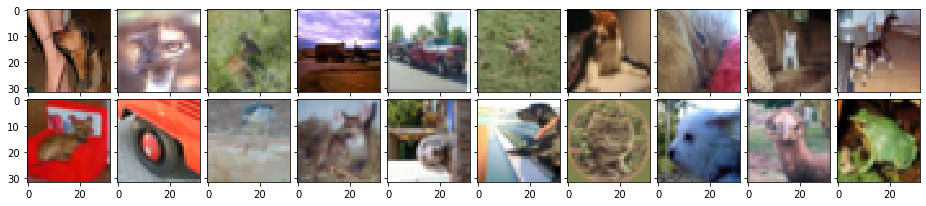

In [141]:
df_densenet_ra_2_5_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [142]:
df_densenet_ra_2_5_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.800650  9.851829e-06  8.126917e+04                   3   
1         0.992131  1.217273e-05  8.150434e+04                   3   
2         0.998805  1.159369e-05  8.615071e+04                   2   
3         0.999989  1.128641e-05  8.860115e+04                   0   
4         0.999993  6.264517e-06  1.596281e+05                   9   
5         0.999992  5.347182e-06  1.870130e+05                   4   
6         0.999995  4.692158e-06  2.131205e+05                   5   
7         0.997054  4.320059e-06  2.307963e+05                   4   
8         0.999801  2.758338e-06  3.624649e+05                   3   
9         0.999913  2.158153e-06  4.633190e+05                   7   
10        0.999997  1.850948e-06  5.402618e+05                   3   
11        0.796703  1.466766e-06  5.431698e+05                   3   
12        0.999881  1.716580e-06  5.824845e+05                   4   
13        0.999995  1.382798e-06  7.231681e+05                   3   
14        0.999991  1.307265e-06  7.649491e+05                   3   
15        0.446514  3.351588e-07  1.332246e+06                   8   
16        0.999998  6.823525e-07  1.465516e+06                   6   
17        0.999876  2.778032e-07  3.599223e+06                   2   
18        0.997195  9.759902e-08  1.021726e+07                   7   
19        1.000000  8.817352e-11  1.134127e+10                   6   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       2061  
1              cat              2             bird       5862  
2             bird              4             deer       9386  
3         airplane              9            truck       3957  
4            truck              1       automobile       9227  
5             deer              2             bird       1325  
6              dog              3              cat         61  
7             deer              3              cat        916  
8              cat              5              dog       4740  
9            horse              3              cat       4485  
10             cat              5              dog       8469  
11             cat              9            truck       3789  
12            deer              2             bird       1248  
13             cat              4             deer       5417  
14             cat              5              dog       7620  
15            ship              5              dog       2525  
16            frog              3              cat       5511  
17            bird              5              dog       5098  
18           horse              2             bird       2592  
19            frog              3              cat       2405

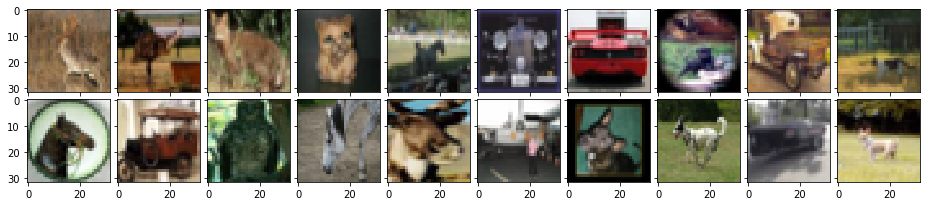

In [143]:
df_densenet_ra_2_5_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [144]:
df_densenet_ra_2_5_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999802  6.228522e-05  1.605199e+04                   2   
1         0.956955  4.801135e-05  1.993185e+04                   7   
2         0.999263  4.995008e-05  2.000524e+04                   4   
3         0.999954  4.431286e-05  2.256578e+04                   5   
4         0.872498  2.953563e-05  2.954052e+04                   0   
5         0.982307  1.678094e-05  5.853705e+04                   9   
6         0.995198  1.523278e-05  6.533263e+04                   9   
7         0.713014  1.080462e-05  6.599159e+04                   8   
8         0.999896  1.397156e-05  7.156654e+04                   9   
9         0.995222  1.112393e-05  8.946680e+04                   4   
10        0.939889  7.667076e-06  1.225876e+05                   3   
11        0.999982  7.896424e-06  1.266373e+05                   9   
12        0.999739  7.490507e-06  1.334674e+05                   3   
13        0.998065  4.886333e-06  2.042565e+05                   2   
14        0.957278  4.119330e-06  2.323868e+05                   5   
15        0.999655  3.157935e-06  3.165533e+05                   9   
16        0.999967  3.073024e-06  3.254014e+05                   3   
17        0.997234  1.984343e-06  5.025512e+05                   2   
18        0.596461  4.691775e-07  1.271290e+06                   9   
19        0.999977  9.015311e-08  1.109198e+07                   4   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              4             deer        977  
1            horse              2             bird        571  
2             deer              3              cat        668  
3              dog              3              cat        757  
4         airplane              7            horse       1426  
5            truck              1       automobile        382  
6            truck              1       automobile        309  
7             ship              5              dog       1060  
8            truck              1       automobile        336  
9             deer              3              cat        772  
10             cat              7            horse       1412  
11           truck              1       automobile        391  
12             cat              2             bird        528  
13            bird              7            horse       1414  
14             dog              4             deer        996  
15           truck              0         airplane        167  
16             cat              5              dog       1126  
17            bird              5              dog       1117  
18           truck              8             ship       1623  
19            deer              5              dog       1076

### densenet, RA(2,20)

In [145]:
output = search_path + 'densenet_BC_100_12_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9168
 -> Sanity Check: 9168 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.921569  0.9400  0.930693   1000.0000
1 automobile   0.960199  0.9650  0.962594   1000.0000
2 bird         0.899696  0.8880  0.893810   1000.0000
3 cat          0.791825  0.8330  0.811891   1000.0000
4  deer        0.925553  0.9200  0.922768   1000.0000
5 dog          0.883103  0.8310  0.856260   1000.0000
6 frog         0.940358  0.9460  0.943170   1000.0000
7 horse        0.955010  0.9340  0.944388   1000.0000
8 ship         0.951244  0.9560  0.953616   1000.0000
9 truck        0.943676  0.9550  0.949304   1000.0000
accuracy       0.916800  0.9168  0.916800      0.9168
macro avg      0.917223  0.9168  0.916849  10000.0000
weighted avg   0.917223  0.9168  0.916849  10000.0000


In [146]:
output = search_path + 'densenet_BC_100_12_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.829
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.798030   0.810  0.803970   200.000
1 automobile   0.949045   0.745  0.834734   200.000
2 bird         0.803922   0.820  0.811881   200.000
3 cat          0.714286   0.750  0.731707   200.000
4  deer        0.841837   0.825  0.833333   200.000
5 dog          0.819149   0.770  0.793814   200.000
6 frog         0.897959   0.880  0.888889   200.000
7 horse        0.873096   0.860  0.866499   200.000
8 ship         0.866029   0.905  0.885086   200.000
9 truck        0.770833   0.925  0.840909   200.000
accuracy       0.829000   0.829  0.829000     0.829
macro avg      0.833418   0.829  0.829082  2000.000
weighted avg   0.833418   0.829  0.829082  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


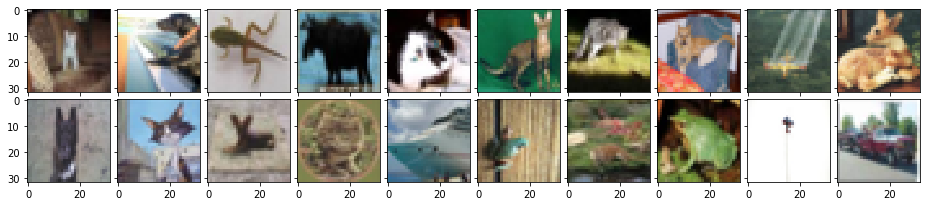

In [147]:
df_densenet_ra_2_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [148]:
df_densenet_ra_2_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.993151  3.740463e-05  2.655154e+04                   3   
1         0.926264  2.883286e-05  3.212528e+04                   2   
2         0.999909  2.832835e-05  3.529712e+04                   0   
3         0.999974  2.606528e-05  3.836421e+04                   7   
4         0.999979  1.506740e-05  6.636705e+04                   5   
5         0.999803  1.054540e-05  9.480935e+04                   4   
6         0.999728  7.905124e-06  1.264658e+05                   2   
7         0.999989  6.876061e-06  1.454306e+05                   3   
8         0.999993  3.932442e-06  2.542932e+05                   8   
9         0.681665  2.524843e-06  2.699832e+05                   3   
10        0.999993  3.174373e-06  3.150207e+05                   3   
11        0.870594  2.138615e-06  4.070832e+05                   0   
12        0.999398  2.159006e-06  4.628973e+05                   4   
13        0.999981  1.367727e-06  7.311261e+05                   6   
14        0.999999  1.073481e-06  9.315473e+05                   0   
15        0.937417  3.583740e-07  2.615750e+06                   2   
16        0.999972  2.137104e-07  4.679098e+06                   4   
17        1.000000  7.223171e-08  1.384433e+07                   6   
18        1.000000  2.468465e-08  4.051100e+07                   2   
19        1.000000  2.244851e-08  4.454638e+07                   9   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       4740  
1             bird              5              dog       2525  
2         airplane              6             frog       8573  
3            horse              4             deer       9840  
4              dog              3              cat       7384  
5             deer              3              cat       7881  
6             bird              3              cat       5908  
7              cat              5              dog       4051  
8             ship              0         airplane        378  
9              cat              4             deer       3297  
10             cat              5              dog       2161  
11        airplane              3              cat       8778  
12            deer              5              dog       3192  
13            frog              3              cat       5511  
14        airplane              8             ship        665  
15            bird              6             frog       1935  
16            deer              3              cat       4965  
17            frog              3              cat       2405  
18            bird              0         airplane       3444  
19           truck              1       automobile       9227

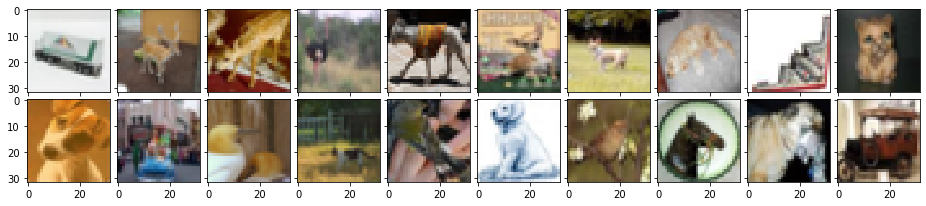

In [149]:
df_densenet_ra_2_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [150]:
df_densenet_ra_2_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.764676  1.927351e-04  3.967497e+03                   0   
1         0.950902  2.189423e-04  4.343162e+03                   0   
2         0.950164  2.062789e-04  4.606210e+03                   6   
3         0.921630  1.831568e-04  5.031919e+03                   5   
4         0.999746  1.773234e-04  5.637982e+03                   7   
5         0.997061  1.382615e-04  7.211412e+03                   4   
6         0.999184  1.225480e-04  8.153408e+03                   4   
7         0.770954  6.096006e-05  1.264688e+04                   3   
8         0.995199  7.638460e-05  1.302879e+04                   3   
9         0.999945  5.403101e-05  1.850687e+04                   5   
10        0.999428  2.864468e-05  3.489052e+04                   3   
11        0.997520  2.337239e-05  4.267943e+04                   9   
12        0.946385  2.039528e-05  4.640215e+04                   3   
13        0.999721  1.350421e-05  7.403030e+04                   4   
14        0.994212  7.407912e-06  1.342095e+05                   3   
15        0.996286  4.831360e-06  2.062124e+05                   3   
16        0.990133  3.437658e-06  2.880256e+05                   6   
17        0.832951  2.055255e-06  4.052785e+05                   3   
18        0.999996  3.569143e-07  2.801782e+06                   7   
19        0.999775  6.696280e-08  1.493031e+07                   9   

   label_predicted  correct_label correct_label_id  img_index  
0         airplane              9            truck       1973  
1         airplane              4             deer        837  
2             frog              4             deer        910  
3              dog              2             bird        482  
4            horse              5              dog       1121  
5             deer              5              dog       1072  
6             deer              5              dog       1076  
7              cat              5              dog       1134  
8              cat              0         airplane          7  
9              dog              3              cat        757  
10             cat              5              dog       1139  
11           truck              1       automobile        381  
12             cat              2             bird        420  
13            deer              3              cat        772  
14             cat              2             bird        426  
15             cat              5              dog       1045  
16            frog              2             bird        471  
17             cat              7            horse       1412  
18           horse              5              dog       1164  
19           truck              1       automobile        391

### densenet, RA(3,20)

In [151]:
output = search_path + 'densenet_BC_100_12_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9076
 -> Sanity Check: 9076 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.899322  0.9290  0.913920   1000.0000
1 automobile   0.954910  0.9530  0.953954   1000.0000
2 bird         0.871032  0.8780  0.874502   1000.0000
3 cat          0.807385  0.8090  0.808192   1000.0000
4  deer        0.898239  0.9180  0.908012   1000.0000
5 dog          0.890217  0.8190  0.853125   1000.0000
6 frog         0.927308  0.9440  0.935580   1000.0000
7 horse        0.938570  0.9320  0.935273   1000.0000
8 ship         0.940020  0.9560  0.947942   1000.0000
9 truck        0.948433  0.9380  0.943188   1000.0000
accuracy       0.907600  0.9076  0.907600      0.9076
macro avg      0.907544  0.9076  0.907369  10000.0000
weighted avg   0.907544  0.9076  0.907369  10000.0000


In [152]:
output = search_path + 'densenet_BC_100_12_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8095
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.774510  0.7900  0.782178   200.0000
1 automobile   0.918129  0.7850  0.846361   200.0000
2 bird         0.788177  0.8000  0.794045   200.0000
3 cat          0.671362  0.7150  0.692494   200.0000
4  deer        0.831683  0.8400  0.835821   200.0000
5 dog          0.851852  0.6900  0.762431   200.0000
6 frog         0.840000  0.8400  0.840000   200.0000
7 horse        0.823810  0.8650  0.843902   200.0000
8 ship         0.823810  0.8650  0.843902   200.0000
9 truck        0.804444  0.9050  0.851765   200.0000
accuracy       0.809500  0.8095  0.809500     0.8095
macro avg      0.812778  0.8095  0.809290  2000.0000
weighted avg   0.812778  0.8095  0.809290  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


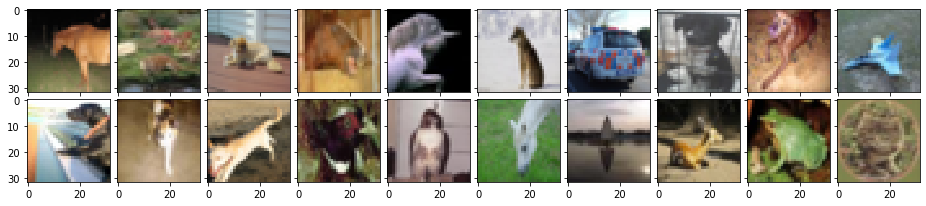

In [153]:
df_densenet_ra_3_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [154]:
df_densenet_ra_3_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999697  2.582991e-05  3.870306e+04                   4   
1         0.988836  1.896691e-05  5.213478e+04                   4   
2         0.999949  1.889461e-05  5.292246e+04                   3   
3         0.991221  1.820815e-05  5.443830e+04                   3   
4         0.784463  1.312460e-05  5.977043e+04                   2   
5         0.695543  1.145100e-05  6.074080e+04                   2   
6         0.996016  1.368873e-05  7.276179e+04                   9   
7         0.654117  6.452447e-06  1.013751e+05                   8   
8         0.999862  9.137615e-06  1.094226e+05                   6   
9         0.999991  7.151083e-06  1.398377e+05                   2   
10        0.554010  3.766732e-06  1.470798e+05                   0   
11        0.999962  5.630297e-06  1.776038e+05                   5   
12        0.995148  5.493122e-06  1.811626e+05                   0   
13        0.997038  5.290493e-06  1.884583e+05                   6   
14        0.992995  3.101866e-06  3.201284e+05                   5   
15        0.802862  1.297050e-06  6.189909e+05                   4   
16        0.999888  1.308678e-06  7.640443e+05                   0   
17        0.999999  5.916364e-07  1.690225e+06                   0   
18        1.000000  5.051788e-07  1.979496e+06                   6   
19        0.999149  4.429299e-07  2.255774e+06                   6   

   label_predicted  correct_label correct_label_id  img_index  
0             deer              7            horse       4892  
1             deer              3              cat       4965  
2              cat              5              dog       5609  
3              cat              7            horse       6151  
4             bird              7            horse       2010  
5             bird              5              dog       6257  
6            truck              1       automobile       1131  
7             ship              5              dog       2590  
8             frog              5              dog       8428  
9             bird              0         airplane       5310  
10        airplane              5              dog       2525  
11             dog              3              cat       7099  
12        airplane              5              dog       4942  
13            frog              2             bird       8166  
14             dog              2             bird       4646  
15            deer              7            horse       4309  
16        airplane              8             ship       5548  
17        airplane              4             deer       2581  
18            frog              3              cat       2405  
19            frog              3              cat       5511

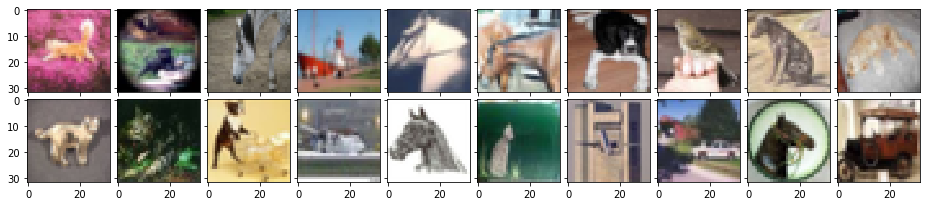

In [155]:
df_densenet_ra_3_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [156]:
df_densenet_ra_3_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.996307  3.179008e-04  3.134017e+03                   2   
1         0.620047  1.707050e-04  3.632269e+03                   8   
2         0.997446  2.689205e-04  3.709073e+03                   2   
3         0.985097  2.649529e-04  3.718008e+03                   0   
4         0.999758  2.159648e-04  4.629264e+03                   8   
5         0.775721  1.651032e-04  4.698398e+03                   0   
6         0.999799  2.009110e-04  4.976327e+03                   3   
7         0.829342  1.656696e-04  5.006000e+03                   3   
8         0.996825  1.797501e-04  5.545616e+03                   3   
9         0.998330  1.565231e-04  6.378163e+03                   3   
10        0.999888  1.075608e-04  9.296027e+03                   5   
11        0.999781  8.724994e-05  1.145882e+04                   6   
12        0.997951  8.341522e-05  1.196365e+04                   7   
13        0.999831  7.761025e-05  1.288272e+04                   8   
14        0.997495  1.925062e-05  5.181626e+04                   3   
15        0.999967  1.232810e-05  8.111284e+04                   2   
16        0.616344  6.282060e-06  9.811173e+04                   3   
17        0.902344  8.990524e-06  1.003661e+05                   9   
18        0.967689  1.584838e-06  6.105916e+05                   6   
19        0.999996  8.038656e-07  1.243984e+06                   9   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              3              cat        733  
1             ship              5              dog       1060  
2             bird              7            horse       1414  
3         airplane              8             ship       1718  
4             ship              7            horse       1427  
5         airplane              7            horse       1406  
6              cat              5              dog       1052  
7              cat              2             bird        557  
8              cat              5              dog       1148  
9              cat              5              dog       1134  
10             dog              3              cat        664  
11            frog              3              cat        739  
12           horse              5              dog       1059  
13            ship              0         airplane        182  
14             cat              7            horse       1538  
15            bird              3              cat        611  
16             cat              0         airplane         98  
17           truck              1       automobile        365  
18            frog              7            horse       1412  
19           truck              1       automobile        391

### compare all densenet

The number of common misclassifications across all models: 2
{2525, 2405}


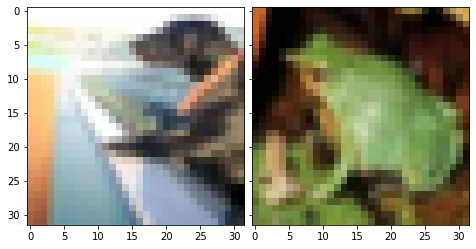

In [157]:
# View intersection of errors
#change the intersect
intersect = set(df_densenet_errors.img_index) & \
            set(df_densenet_ra_1_20_errors.img_index) & \
            set(df_densenet_ra_2_5_errors.img_index) & \
            set(df_densenet_ra_2_20_errors.img_index) & \
            set(df_densenet_ra_3_20_errors.img_index)

print("The number of common misclassifications across all models:", len(intersect))
print(intersect)

images_to_print = []

for i in intersect:
    img=Image.fromarray(test_data_CIFAR10[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [158]:
df = pd.DataFrame()

# change these labels

# intersect = set(df_resnet32_errors.img_index) & \
#             set(df_resnet32_errors_ra_2_5.img_index) & \
#             set(df_resnet32_errors_ra_2_20.img_index) & \
#             set(df_resnet32_errors_ra_3_20.img_index)

for m, me in [('densenet', df_densenet_errors.img_index), 
              ('densenet_ra_1_20', df_densenet_ra_1_20_errors.img_index),
              ('densenet_ra_2_5', df_densenet_ra_2_5_errors.img_index), 
              ('densenet_ra_2_20', df_densenet_ra_2_20_errors.img_index), 
              ('densenet_ra_3_20', df_densenet_ra_3_20_errors.img_index)]:
    for e in me:
        df.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df.fillna(False, inplace=True)
cols = df.columns
df.reset_index(inplace=True)
df

index   5830   1969   5511   8728   1772  2525   2804   4614  \
0          densenet   True   True   True   True   True  True   True   True   
1  densenet_ra_1_20  False  False  False  False  False  True  False  False   
2   densenet_ra_2_5  False  False   True  False  False  True  False  False   
3  densenet_ra_2_20  False  False   True  False  False  True  False  False   
4  densenet_ra_3_20  False  False   True  False  False  True  False  False   

    4965    378   7657   2592   6151   9227   7509   9431   5548   7099  \
0   True   True   True   True   True   True   True   True   True   True   
1  False  False   True  False   True   True  False  False   True  False   
2  False  False  False   True  False   True  False  False  False  False   
3   True   True  False  False  False   True  False  False  False  False   
4   True  False  False  False   True  False  False  False   True   True   

    6741  2405   8236   3753   1935   7941   3490   4077   7398    665   2495  \
0   True  True  False  False  False  False  False  False  False  False  False   
1  False  True   True   True   True   True   True   True   True   True   True   
2  False  True  False  False  False  False  False  False  False  False  False   
3  False  True  False  False   True  False  False  False  False   True  False   
4  False  True  False  False  False  False  False  False  False  False  False   

    8573   4931   1506   4740   3202   2061   5862   9386   3957   1325  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True  False  False  False  False  False   
2  False  False  False   True  False   True   True   True   True   True   
3   True  False  False   True  False  False  False  False  False  False   
4  False  False  False  False  False  False  False  False  False  False   

      61    916   4485   8469   3789   1248   5417   7620   5098   9840  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True   True   True  False   
3  False  False  False  False  False  False  False  False  False   True   
4  False  False  False  False  False  False  False  False  False  False   

    7384   7881   5908   4051   3297   2161   8778   3192   3444   4892  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True   True   True   True   True   True   True  False   
4  False  False  False  False  False  False  False  False  False   True   

    5609   2010   6257   1131   2590   8428   5310   4942   8166   4646  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3  False  False  False  False  False  False  False  False  False  False   
4   True   True   True   True   True   True   True   True   True   True   

    4309   2581  
0  False  False  
1  False  False  
2  False  False  
3  False  False  
4   True   True

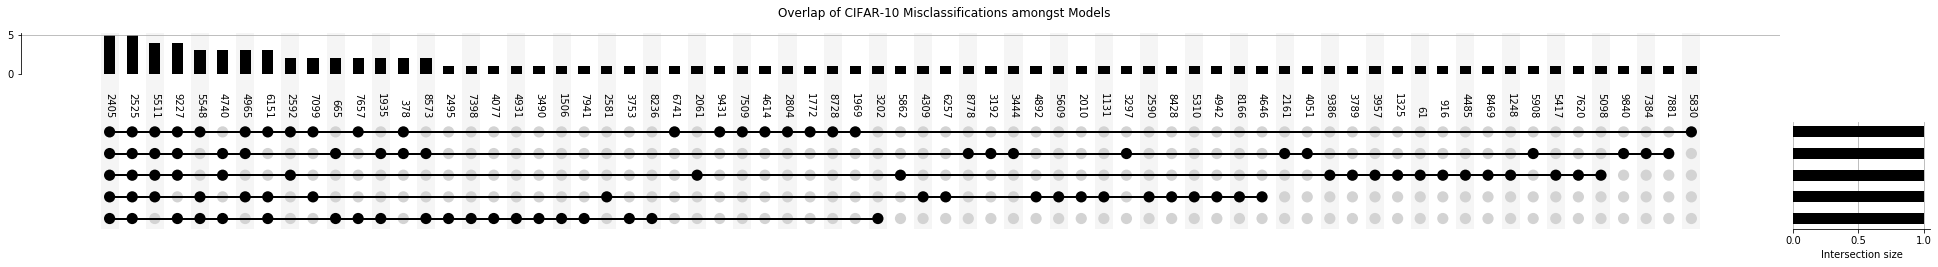

In [159]:
overlap = df.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show()  

In [160]:
# View intersection of errors
intersect101 = set(df_densenet_errors_101.img_index) & \
            set(df_densenet_ra_1_20_errors_101.img_index) & \
            set(df_densenet_ra_2_5_errors_101.img_index) & \
            set(df_densenet_ra_2_20_errors_101.img_index) & \
            set(df_densenet_ra_3_20_errors_101.img_index)

            
print("The number of common misclassifications across all models:", len(intersect101))
print(intersect101)

# View errors 
# df_errors_101 = pd.DataFrame({'resnext_29_4x64' : df_resnext4_errors_101.img_index,
#                              'resnext_29_8x64' : df_resnext8_errors_101.img_index,
#                              'resnet32' : df_resnet32_errors_101.img_index,
#                              'densenet' : df_densenet_errors_101.img_index,
#                              'wrn_28_10' : df_wrn_28_10_errors_101.img_index,
#                              'pyramidnet_basic_110_84' : df_pyramidnet_basic_110_84_errors_101.img_index,
#                              'resnet44' : df_resnet44_errors.img_index})

images_to_print = []

for i in intersect101:
    img=Image.fromarray(test_data_CIFAR101[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect101)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

The number of common misclassifications across all models: 0
set()


IndexError: list index out of range

<Figure size 1152x288 with 0 Axes>

In [161]:
df101 = pd.DataFrame()

for m, me in [('densenet', df_densenet_errors_101.img_index), 
              ('densenet_ra_1_20', df_densenet_ra_1_20_errors_101.img_index), 
              ('densenet_ra_2_5', df_densenet_ra_2_5_errors_101.img_index), 
              ('densenet_ra_2_20', df_densenet_ra_2_20_errors_101.img_index), 
              ('densenet_ra_3_20', df_densenet_ra_3_20_errors_101.img_index)]:
    for e in me:
        df101.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df101.fillna(False, inplace=True)
cols = df101.columns
df101.reset_index(inplace=True)
df101

index    365     76   1126    772   1753   1060    592    600  \
0          densenet   True   True   True   True   True   True   True   True   
1  densenet_ra_1_20  False  False  False   True   True   True  False  False   
2   densenet_ra_2_5  False  False   True   True  False   True  False  False   
3  densenet_ra_2_20  False  False  False   True  False  False  False  False   
4  densenet_ra_3_20   True  False  False  False  False   True  False  False   

     996    671    420   1076    783   1134    602   1148    433    254  \
0   True   True   True   True   True   True   True   True   True   True   
1  False  False  False  False  False   True  False   True  False  False   
2   True  False  False   True  False  False  False  False  False  False   
3  False  False   True   True  False   True  False  False  False  False   
4  False  False  False  False  False   True  False   True  False  False   

     391    336    720    382    692    427    699    641    668   1304  \
0   True   True  False  False  False  False  False  False  False  False   
1  False   True   True   True   True   True   True   True   True   True   
2   True   True  False   True  False  False  False  False   True  False   
3   True  False  False  False  False  False  False  False  False  False   
4   True  False  False  False  False  False  False  False  False  False   

     910    515   1088   1585    392   1761    977    571    757   1426  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True  False  False  False  False   
2  False  False  False  False  False  False   True   True   True   True   
3   True  False  False  False  False  False  False  False   True  False   
4  False  False  False  False  False  False  False  False  False  False   

     309   1412    528   1414    167   1117   1623   1973    837    482  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True  False  False  False   
3  False   True  False  False  False  False  False   True   True   True   
4  False   True  False   True  False  False  False  False  False  False   

    1121   1072      7   1139    381    426   1045    471   1164    733  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True   True   True   True   True   True   True  False   
4  False  False  False  False  False  False  False  False  False   True   

    1718   1427   1406   1052    557    664    739   1059    182   1538  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3  False  False  False  False  False  False  False  False  False  False   
4   True   True   True   True   True   True   True   True   True   True   

     611     98  
0  False  False  
1  False  False  
2  False  False  
3  False  False  
4   True   True

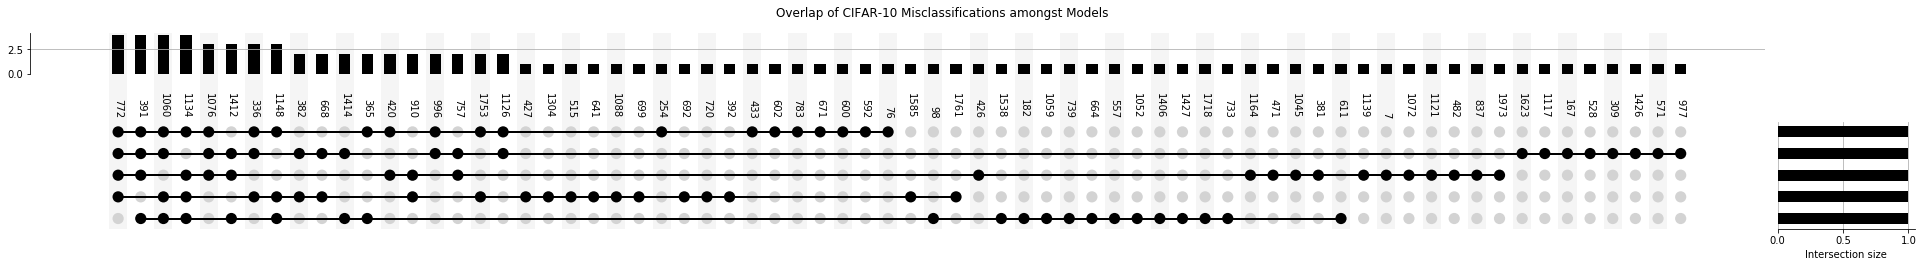

In [162]:
overlap = df101.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show() 

# resnext section

### resnext, no RA

In [163]:
output = search_path + 'resnext_29_4x64/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9535
 -> Sanity Check: 9535 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.960080  0.9620  0.961039   1000.0000
1 automobile   0.980981  0.9800  0.980490   1000.0000
2 bird         0.944779  0.9410  0.942886   1000.0000
3 cat          0.892108  0.8930  0.892554   1000.0000
4  deer        0.942495  0.9670  0.954590   1000.0000
5 dog          0.930612  0.9120  0.921212   1000.0000
6 frog         0.963257  0.9700  0.966617   1000.0000
7 horse        0.983707  0.9660  0.974773   1000.0000
8 ship         0.970090  0.9730  0.971543   1000.0000
9 truck        0.967131  0.9710  0.969062   1000.0000
accuracy       0.953500  0.9535  0.953500      0.9535
macro avg      0.953524  0.9535  0.953477  10000.0000
weighted avg   0.953524  0.9535  0.953477  10000.0000


In [164]:
output = search_path + 'resnext_29_4x64/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8905
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.908602  0.8450  0.875648   200.0000
1 automobile   0.958824  0.8150  0.881081   200.0000
2 bird         0.888350  0.9150  0.901478   200.0000
3 cat          0.827225  0.7900  0.808184   200.0000
4  deer        0.892523  0.9550  0.922705   200.0000
5 dog          0.874346  0.8350  0.854220   200.0000
6 frog         0.921951  0.9450  0.933333   200.0000
7 horse        0.924623  0.9200  0.922306   200.0000
8 ship         0.900000  0.9450  0.921951   200.0000
9 truck        0.824561  0.9400  0.878505   200.0000
accuracy       0.890500  0.8905  0.890500     0.8905
macro avg      0.892100  0.8905  0.889941  2000.0000
weighted avg   0.892100  0.8905  0.889941  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


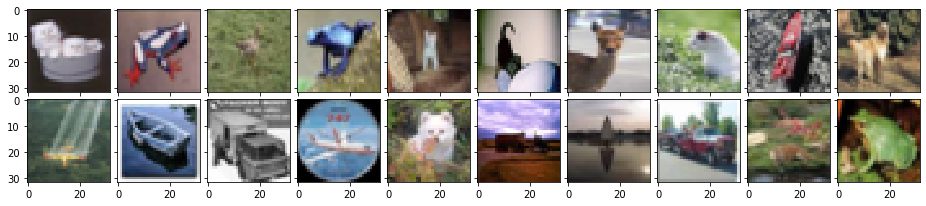

In [165]:
df_resnext_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [166]:
df_resnext_errors

prob_predicted  prob_correct        r_value  label_predicted_id  \
0         0.992864      0.000906    1095.530884                   8   
1         0.995250      0.000898    1107.953735                   0   
2         0.999062      0.000896    1115.018677                   4   
3         0.918964      0.000820    1121.106445                   2   
4         0.986606      0.000761    1295.803101                   3   
5         0.997638      0.000767    1300.490723                   2   
6         0.999297      0.000466    2145.291992                   5   
7         0.987027      0.000440    2243.779785                   2   
8         0.993101      0.000407    2437.718018                   2   
9         0.998823      0.000322    3097.743408                   4   
10        0.999315      0.000308    3246.277588                   8   
11        0.999624      0.000255    3916.698730                   1   
12        0.999411      0.000218    4579.142090                   1   
13        0.996964      0.000155    6434.504883                   8   
14        0.999611      0.000138    7238.125000                   3   
15        0.999634      0.000119    8391.208008                   0   
16        0.999817      0.000087   11441.147461                   0   
17        0.999959      0.000026   37883.054688                   9   
18        0.999969      0.000004  262986.093750                   4   
19        0.999805      0.000003  387136.750000                   6   

   label_predicted  correct_label correct_label_id  img_index  
0             ship              3              cat       9812  
1         airplane              6             frog       4744  
2             deer              2             bird       1325  
3             bird              6             frog       3615  
4              cat              5              dog       4740  
5             bird              5              dog        810  
6              dog              4             deer       1217  
7             bird              3              cat       3052  
8             bird              8             ship       1685  
9             deer              5              dog       4528  
10            ship              0         airplane        378  
11      automobile              8             ship       7559  
12      automobile              9            truck       5455  
13            ship              0         airplane       8743  
14             cat              5              dog       4275  
15        airplane              9            truck       3957  
16        airplane              8             ship       5548  
17           truck              1       automobile       9227  
18            deer              3              cat       4965  
19            frog              3              cat       2405

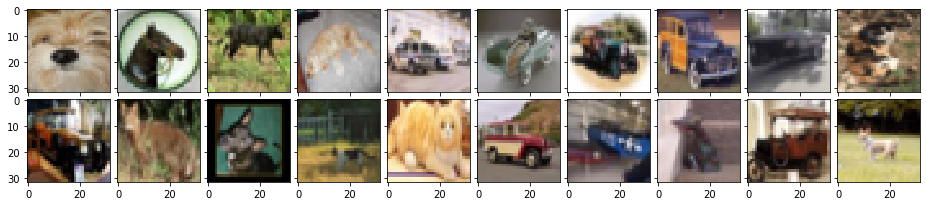

In [167]:
df_resnext_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [168]:
df_resnext_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.996358      0.002389    417.090912                   3   
1         0.887847      0.001992    445.627350                   6   
2         0.868874      0.001934    449.283966                   7   
3         0.995478      0.002200    452.404816                   3   
4         0.996879      0.002081    478.928467                   9   
5         0.994601      0.002016    493.451080                   6   
6         0.997193      0.001984    502.681061                   9   
7         0.998023      0.001683    593.072083                   9   
8         0.847274      0.001398    605.875488                   1   
9         0.995697      0.001643    606.004333                   5   
10        0.978815      0.001334    733.907898                   9   
11        0.987949      0.001264    781.673096                   4   
12        0.998764      0.001169    854.702881                   3   
13        0.986349      0.000486   2029.805908                   4   
14        0.999390      0.000351   2848.285156                   5   
15        0.999462      0.000301   3321.299561                   9   
16        0.999135      0.000232   4311.464355                   8   
17        0.998629      0.000158   6321.289551                   4   
18        0.996014      0.000157   6352.357910                   9   
19        0.999844      0.000012  81720.085938                   4   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       1035  
1             frog              7            horse       1412  
2            horse              3              cat        743  
3              cat              5              dog       1134  
4            truck              1       automobile        368  
5             frog              1       automobile        351  
6            truck              1       automobile        342  
7            truck              1       automobile        378  
8       automobile              8             ship       1623  
9              dog              3              cat        783  
10           truck              1       automobile        344  
11            deer              3              cat        668  
12             cat              5              dog       1126  
13            deer              3              cat        772  
14             dog              3              cat        602  
15           truck              1       automobile        254  
16            ship              0         airplane        131  
17            deer              3              cat        792  
18           truck              1       automobile        391  
19            deer              5              dog       1076

### resnext RA(1,20)

In [169]:
output = search_path + 'resnext_29_4x64_ra_1_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9398
 -> Sanity Check: 9398 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.934847  0.9470  0.940884   1000.0000
1 automobile   0.968127  0.9720  0.970060   1000.0000
2 bird         0.927126  0.9160  0.921529   1000.0000
3 cat          0.862340  0.8770  0.869608   1000.0000
4  deer        0.936821  0.9490  0.942871   1000.0000
5 dog          0.908069  0.8890  0.898434   1000.0000
6 frog         0.969728  0.9610  0.965344   1000.0000
7 horse        0.967611  0.9560  0.961771   1000.0000
8 ship         0.964179  0.9690  0.966584   1000.0000
9 truck        0.960080  0.9620  0.961039   1000.0000
accuracy       0.939800  0.9398  0.939800      0.9398
macro avg      0.939893  0.9398  0.939812  10000.0000
weighted avg   0.939893  0.9398  0.939812  10000.0000


In [170]:
output = search_path + 'resnext_29_4x64_ra_1_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8645
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.887701  0.8300  0.857881   200.0000
1 automobile   0.962733  0.7750  0.858726   200.0000
2 bird         0.882653  0.8650  0.873737   200.0000
3 cat          0.718750  0.8050  0.759434   200.0000
4  deer        0.861244  0.9000  0.880196   200.0000
5 dog          0.857143  0.8400  0.848485   200.0000
6 frog         0.898990  0.8900  0.894472   200.0000
7 horse        0.947090  0.8950  0.920308   200.0000
8 ship         0.866667  0.9100  0.887805   200.0000
9 truck        0.813043  0.9350  0.869767   200.0000
accuracy       0.864500  0.8645  0.864500     0.8645
macro avg      0.869601  0.8645  0.865081  2000.0000
weighted avg   0.869601  0.8645  0.865081  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


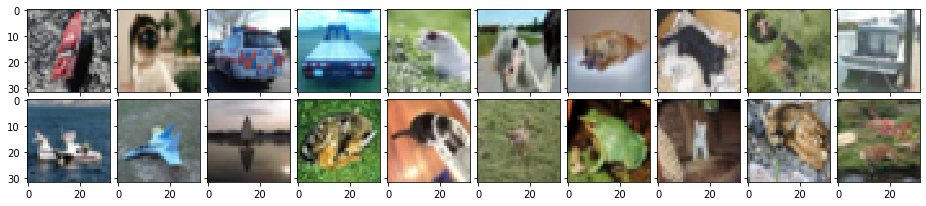

In [171]:
df_resnext_ra_1_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [172]:
df_resnext_ra_1_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.995080  4.653042e-04  2.138557e+03                   2   
1         0.987854  4.444667e-04  2.222561e+03                   5   
2         0.998948  4.306500e-04  2.319627e+03                   9   
3         0.976156  4.187085e-04  2.331349e+03                   1   
4         0.879196  3.471455e-04  2.532645e+03                   2   
5         0.785899  2.956659e-04  2.658066e+03                   5   
6         0.997937  3.124792e-04  3.193612e+03                   3   
7         0.999640  2.950157e-04  3.388431e+03                   3   
8         0.983999  2.476592e-04  3.973199e+03                   2   
9         0.998978  2.013138e-04  4.962294e+03                   9   
10        0.999788  1.600096e-04  6.248300e+03                   8   
11        0.999790  1.377811e-04  7.256364e+03                   2   
12        0.999682  1.171849e-04  8.530815e+03                   0   
13        0.998141  1.034882e-04  9.644976e+03                   6   
14        0.999943  4.921342e-05  2.031851e+04                   5   
15        0.999933  2.423075e-05  4.126710e+04                   4   
16        0.999968  2.081134e-05  4.804920e+04                   6   
17        0.999831  8.420096e-06  1.187434e+05                   3   
18        0.999957  8.370439e-06  1.194630e+05                   3   
19        0.999997  8.335508e-07  1.199683e+06                   4   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              8             ship       1685  
1              dog              3              cat       1779  
2            truck              1       automobile       1131  
3       automobile              9            truck       4931  
4             bird              3              cat       3052  
5              dog              2             bird       7657  
6              cat              5              dog       6627  
7              cat              5              dog        275  
8             bird              4             deer       5369  
9            truck              8             ship       4910  
10            ship              0         airplane       4784  
11            bird              0         airplane       5310  
12        airplane              8             ship       5548  
13            frog              4             deer       2128  
14             dog              3              cat       9819  
15            deer              2             bird       1325  
16            frog              3              cat       2405  
17             cat              5              dog       4740  
18             cat              4             deer       3753  
19            deer              3              cat       4965

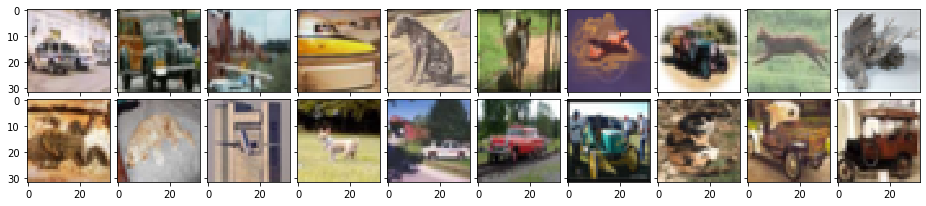

In [173]:
df_resnext_ra_1_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [174]:
df_resnext_ra_1_20_errors_101

prob_predicted  prob_correct        r_value  label_predicted_id  \
0         0.998754      0.000976    1023.014587                   9   
1         0.999033      0.000912    1094.967896                   9   
2         0.976201      0.000812    1201.540283                   8   
3         0.976526      0.000810    1205.361084                   8   
4         0.983552      0.000737    1335.387329                   3   
5         0.999400      0.000588    1698.652466                   4   
6         0.992730      0.000560    1774.108521                   6   
7         0.998237      0.000484    2062.090332                   9   
8         0.998556      0.000410    2437.677490                   4   
9         0.938486      0.000291    3221.226807                   0   
10        0.994352      0.000287    3467.479492                   3   
11        0.999718      0.000238    4200.702637                   3   
12        0.888376      0.000168    5286.653809                   3   
13        0.999840      0.000042   23646.187500                   4   
14        0.997255      0.000041   24469.103516                   0   
15        0.999964      0.000025   39880.476562                   9   
16        0.999896      0.000023   43616.148438                   9   
17        0.999462      0.000016   61015.003906                   5   
18        0.999979      0.000009  115127.695312                   9   
19        0.999972      0.000002  582312.875000                   9   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        368  
1            truck              1       automobile        392  
2             ship              0         airplane         76  
3             ship              0         airplane        116  
4              cat              5              dog       1148  
5             deer              7            horse       1596  
6             frog              0         airplane        102  
7            truck              1       automobile        342  
8             deer              3              cat        671  
9         airplane              2             bird        433  
10             cat              6             frog       1291  
11             cat              5              dog       1134  
12             cat              0         airplane         98  
13            deer              5              dog       1076  
14        airplane              1       automobile        365  
15           truck              1       automobile        251  
16           truck              1       automobile        379  
17             dog              3              cat        783  
18           truck              1       automobile        336  
19           truck              1       automobile        391

### resnext, RA(2,5)

In [175]:
output = search_path + 'resnext_29_4x64d_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9403
 -> Sanity Check: 9403 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.941061  0.9580  0.949455   1000.0000
1 automobile   0.978894  0.9740  0.976441   1000.0000
2 bird         0.946429  0.9010  0.923156   1000.0000
3 cat          0.869960  0.8630  0.866466   1000.0000
4  deer        0.935294  0.9540  0.944554   1000.0000
5 dog          0.885035  0.8930  0.889000   1000.0000
6 frog         0.944063  0.9620  0.952947   1000.0000
7 horse        0.972837  0.9670  0.969910   1000.0000
8 ship         0.955709  0.9710  0.963294   1000.0000
9 truck        0.974619  0.9600  0.967254   1000.0000
accuracy       0.940300  0.9403  0.940300      0.9403
macro avg      0.940390  0.9403  0.940248  10000.0000
weighted avg   0.940390  0.9403  0.940248  10000.0000


In [176]:
output = search_path + 'resnext_29_4x64d_ra_2_5/predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8455
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.849162  0.7600  0.802111   200.0000
1 automobile   0.950311  0.7650  0.847645   200.0000
2 bird         0.855670  0.8300  0.842640   200.0000
3 cat          0.752427  0.7750  0.763547   200.0000
4  deer        0.837321  0.8750  0.855746   200.0000
5 dog          0.834197  0.8050  0.819338   200.0000
6 frog         0.859903  0.8900  0.874693   200.0000
7 horse        0.897959  0.8800  0.888889   200.0000
8 ship         0.873239  0.9300  0.900726   200.0000
9 truck        0.780992  0.9450  0.855204   200.0000
accuracy       0.845500  0.8455  0.845500     0.8455
macro avg      0.849118  0.8455  0.845054  2000.0000
weighted avg   0.849118  0.8455  0.845054  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


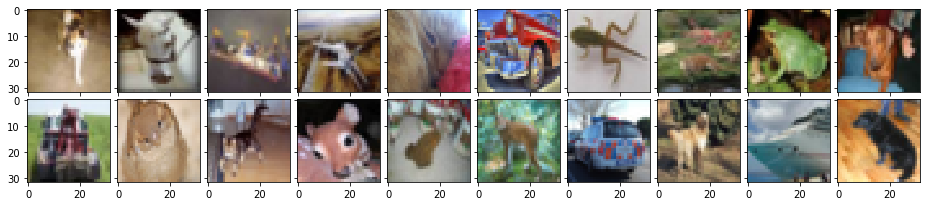

In [177]:
df_resnext_ra_2_5_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [178]:
df_resnext_ra_2_5_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999435      0.000123   8112.354004                   5   
1         0.999335      0.000108   9229.202148                   5   
2         0.999107      0.000108   9265.864258                   6   
3         0.999546      0.000099  10141.971680                   4   
4         0.999422      0.000096  10436.019531                   4   
5         0.999766      0.000088  11321.538086                   9   
6         0.998814      0.000087  11443.451172                   0   
7         0.999244      0.000087  11486.103516                   4   
8         0.999167      0.000084  11829.608398                   6   
9         0.999664      0.000080  12511.045898                   3   
10        0.999554      0.000078  12789.964844                   8   
11        0.999413      0.000072  13879.416016                   3   
12        0.999396      0.000064  15719.822266                   7   
13        0.999614      0.000061  16346.745117                   3   
14        0.999774      0.000060  16598.058594                   3   
15        0.999578      0.000055  18159.353516                   5   
16        0.999750      0.000043  23277.033203                   9   
17        0.999690      0.000041  24105.417969                   4   
18        0.999886      0.000035  28231.826172                   0   
19        0.999923      0.000032  31266.000000                   3   

   label_predicted  correct_label correct_label_id  img_index  
0              dog              3              cat       7099  
1              dog              7            horse       2895  
2             frog              8             ship       5398  
3             deer              0         airplane       3097  
4             deer              3              cat        916  
5            truck              1       automobile       7892  
6         airplane              6             frog       8573  
7             deer              3              cat       4965  
8             frog              3              cat       2405  
9              cat              5              dog       8410  
10            ship              9            truck        213  
11             cat              2             bird       7761  
12           horse              3              cat       4485  
13             cat              4             deer       4112  
14             cat              6             frog         59  
15             dog              4             deer       8354  
16           truck              1       automobile       1131  
17            deer              5              dog       4528  
18        airplane              8             ship        665  
19             cat              5              dog       3236

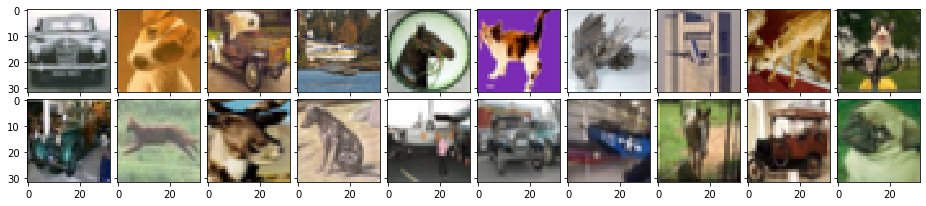

In [179]:
df_resnext_ra_2_5_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [180]:
df_resnext_ra_2_5_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.989009      0.001734    570.290894                   9   
1         0.991720      0.001712    579.170349                   3   
2         0.997831      0.001693    589.532410                   9   
3         0.979016      0.001634    599.144958                   8   
4         0.551262      0.000857    643.412354                   3   
5         0.996038      0.001451    686.595215                   5   
6         0.810740      0.001179    687.881165                   6   
7         0.962519      0.001367    703.855408                   3   
8         0.928624      0.001312    707.739136                   3   
9         0.649154      0.000871    745.641174                   7   
10        0.997557      0.000948   1052.010010                   9   
11        0.747652      0.000529   1413.067383                   4   
12        0.998150      0.000505   1977.813965                   5   
13        0.991432      0.000255   3881.241211                   3   
14        0.998568      0.000236   4225.872070                   9   
15        0.999705      0.000196   5103.888184                   9   
16        0.999715      0.000066  15069.614258                   8   
17        0.999875      0.000064  15645.773438                   4   
18        0.999499      0.000060  16612.121094                   9   
19        0.999921      0.000020  48821.269531                   6   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        337  
1              cat              5              dog       1139  
2            truck              1       automobile        336  
3             ship              0         airplane        187  
4              cat              7            horse       1412  
5              dog              3              cat        766  
6             frog              2             bird        433  
7              cat              0         airplane         98  
8              cat              4             deer        910  
9            horse              3              cat        706  
10           truck              1       automobile        345  
11            deer              3              cat        671  
12             dog              4             deer        996  
13             cat              5              dog       1148  
14           truck              0         airplane        167  
15           truck              1       automobile        277  
16            ship              0         airplane        131  
17            deer              7            horse       1596  
18           truck              1       automobile        391  
19            frog              5              dog       1102

### resnext, RA(2,20)

In [181]:
output = './resnext_29_4x64_ra_2_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)

FileNotFoundError: [Errno 2] No such file or directory: './resnext_29_4x64_ra_2_20/ predictions_400_refined50.npz'

In [ ]:
output = search_path + 'resnext_29_4x64_ra_2_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)

In [ ]:
df_resnext_ra_2_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [ ]:
df_resnext_ra_2_20_errors

In [ ]:
df_resnext_ra_2_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [ ]:
df_resnext_ra_2_20_errors_101

### resnext, RA(3,20)

In [ ]:
output = search_path + 'resnext_29_4x64_ra_3_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)

In [ ]:
output = search_path + 'resnext_29_4x64_ra_3_20/ predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)

In [ ]:
df_resnext_ra_3_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [ ]:
df_resnext_ra_3_20_errors

In [ ]:
df_resnext_ra_3_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [ ]:
df_resnext_ra_3_20_errors_101

### comparison of missed images

In [ ]:
# View intersection of errors
#change the intersect
intersect = set(df_resnext_errors.img_index) & \
            set(df_resnext_ra_1_20_errors.img_index) & \
            set(df_resnext_ra_2_5_errors.img_index) & \
            set(df_resnext_ra_2_20_errors.img_index) & \
            set(df_resnext_ra_3_20_errors.img_index)

print("The number of common misclassifications across all models:", len(intersect))
print(intersect)
images_to_print = []
for i in intersect:
    img=Image.fromarray(test_data_CIFAR10[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect)), axes_pad=0.1,  )
for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [ ]:
df = pd.DataFrame()

# change these labels

# intersect = set(df_resnet32_errors.img_index) & \
#             set(df_resnet32_errors_ra_2_5.img_index) & \
#             set(df_resnet32_errors_ra_2_20.img_index) & \
#             set(df_resnet32_errors_ra_3_20.img_index)

for m, me in [('resnext', df_resnext_errors.img_index), 
              ('resnext_ra_1_20', df_resnext_ra_1_20_errors.img_index),
              ('resnext_ra_2_5', df_resnext_ra_2_5_errors.img_index), 
              ('resnext_ra_2_20', df_resnext_ra_2_20_errors.img_index), 
              ('resnext_ra_3_20', df_resnext_ra_3_20_errors.img_index)]:
    for e in me:
        df.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df.fillna(False, inplace=True)
cols = df.columns
df.reset_index(inplace=True)
df

In [ ]:
overlap = df.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show()  

In [ ]:
# View intersection of errors
intersect101 = set(df_resnext_errors_101.img_index) & \
            set(df_resnext_ra_1_20_errors_101.img_index) & \
            set(df_resnext_ra_2_5_errors_101.img_index) & \
            set(df_resnext_ra_2_20_errors_101.img_index) & \
            set(df_resnext_ra_3_20_errors_101.img_index)

            
print("The number of common misclassifications across all models:", len(intersect101))
print(intersect101)

# View errors 
# df_errors_101 = pd.DataFrame({'resnext_29_4x64' : df_resnext4_errors_101.img_index,
#                              'resnext_29_8x64' : df_resnext8_errors_101.img_index,
#                              'resnet32' : df_resnet32_errors_101.img_index,
#                              'densenet' : df_densenet_errors_101.img_index,
#                              'wrn_28_10' : df_wrn_28_10_errors_101.img_index,
#                              'pyramidnet_basic_110_84' : df_pyramidnet_basic_110_84_errors_101.img_index,
#                              'resnet44' : df_resnet44_errors.img_index})

images_to_print = []

for i in intersect101:
    img=Image.fromarray(test_data_CIFAR101[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect101)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [ ]:
df101 = pd.DataFrame()

for m, me in [('resnext', df_resnext_errors_101.img_index), 
              ('resnext_ra_1_20', df_resnext_ra_2_5_errors_101.img_index),
              ('resnext_ra_2_5', df_resnext_ra_2_5_errors_101.img_index), 
              ('resnext_ra_2_20', df_resnext_ra_2_20_errors_101.img_index), 
              ('resnext_ra_3_20', df_resnext_ra_3_20_errors_101.img_index)]:
    for e in me:
        df101.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df101.fillna(False, inplace=True)
cols = df101.columns
df101.reset_index(inplace=True)
df101

In [ ]:
overlap = df101.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show() 